## 0. Setup

In [384]:
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor, LGBMClassifier, plot_tree, create_tree_digraph, plot_metric
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

import preprocessing as pp
import train_test_sets

warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)


#mri_subs_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_Data_Voxels_894.parquet"
#mri_areas_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_Data_Areas_890.csv" 
#bb_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/BigBrain.xlsx"
#ids_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/participants_nkienhanced.tsv"

mri_subs_path_v2 = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet" 
mri_subs_path_v1 = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894.parquet"
dict_dkt_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Dict_structures_DKT.csv"
dict_econo_path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Dict_structures.csv"

In [416]:
def read_database(atlas):
    if atlas == 'Economo':
        # read df
        df = pd.read_parquet(mri_subs_path_v1) 
        df[['hemisphere','atlasEcono', 'handedness','sex', 'age']] = df[['hemisphere','atlasEcono', 'handedness','sex', 'age']].astype('int32')
        # add bb
        df = pp.bb_features(bb_path, df)
        df = df.dropna()
        # add name strutures and lobes
        Dict_structures_econo = pd.read_csv(dict_econo_path, sep=';', header=None)
        df = df.merge(Dict_structures_econo, how='left', left_on='atlasEcono', right_on=0)
        df = df.rename(columns = {1:'lobe', 2:'structure_name'})
        df = df.drop(columns=0)
    if atlas == 'DKT':
        # read df
        df = pd.read_parquet(mri_subs_path_v2) 
        df = df[df.atlasDF != -1.0]
        df = df.rename(columns = {'h_atlasDF':'h_structure'})
        # add name strutures and lobes
        Dict_structures_dkt = pd.read_csv(dict_dkt_path, sep=',', header=None)
        Dict_structures_dkt = Dict_structures_dkt.rename(columns = {2:'structure_name', 3:'lobe_name', 4:'lobe' })
        Dict_structures_dkt = Dict_structures_dkt.drop(columns=[0,1])
        df = df.join(Dict_structures_dkt, on='atlasDF') 
    return df

In [492]:
#df = read_database('Economo')
#df[['hemisphere','atlasEcono', 'h_structure', 'structure_name','lobe']].head()

In [495]:
df = read_database('DKT')
df[['hemisphere','atlasDF', 'h_structure', 'structure_name','lobe_name','lobe']].head()

hemisphere  atlasDF h_structure          structure_name  lobe_name  lobe
1         0.0     10.0         010       Isthmus Cingulate   Parietal   5.0
2         0.0     11.0         011       Lateral Occipital  Occipital   4.0
3         0.0     12.0         012  Lateral Orbito Frontal    Frontal   1.0
4         0.0     13.0         013                 Lingual  Occipital   4.0
5         0.0     14.0         014   Medial Orbito Frontal    Frontal   1.0

In [496]:
df.head()

participant   age  sex  handedness  hemisphere  atlasDF      area      curv  \
1   A00008326  59.0  0.0         2.0         0.0     10.0  0.601876 -0.008262   
2   A00008326  59.0  0.0         2.0         0.0     11.0  0.656662 -0.042081   
3   A00008326  59.0  0.0         2.0         0.0     12.0  0.673776 -0.049637   
4   A00008326  59.0  0.0         2.0         0.0     13.0  0.682724 -0.029710   
5   A00008326  59.0  0.0         2.0         0.0     14.0  0.667584 -0.043280   

       sulc  thickness  bigbrain_layer_1  bigbrain_layer_2  bigbrain_layer_3  \
1  0.125957   2.703677          0.109474          0.085556          0.277775   
2 -2.089579   2.515563          0.111468          0.097686          0.282431   
3 -1.078827   2.724164          0.105876          0.084844          0.277359   
4 -0.314644   1.864753          0.113680          0.093940          0.274428   
5 -2.774555   2.320056          0.115373          0.091310          0.273685   

   bigbrain_layer_4  bigbrain_layer_5  bigbrain_layer_6 h_structure  \
1          0.103513          0.205281          0.218400         010   
2          0.106553          0.197702          0.204160         011   
3          0.068916          0.221491          0.241514         012   
4          0.130979          0.186600          0.200373         013   
5          0.076120          0.214898          0.228614         014   

           structure_name  lobe_name  lobe  
1       Isthmus Cingulate   Parietal   5.0  
2       Lateral Occipital  Occipital   4.0  
3  Lateral Orbito Frontal    Frontal   1.0  
4                 Lingual  Occipital   4.0  
5   Medial Orbito Frontal    Frontal   1.0

In [497]:
len(df.participant.unique())

871

-------------------

## 1. Regressao Polinomial e Derivada da Espessura

100%|██████████| 63/63 [00:03<00:00, 18.80it/s]


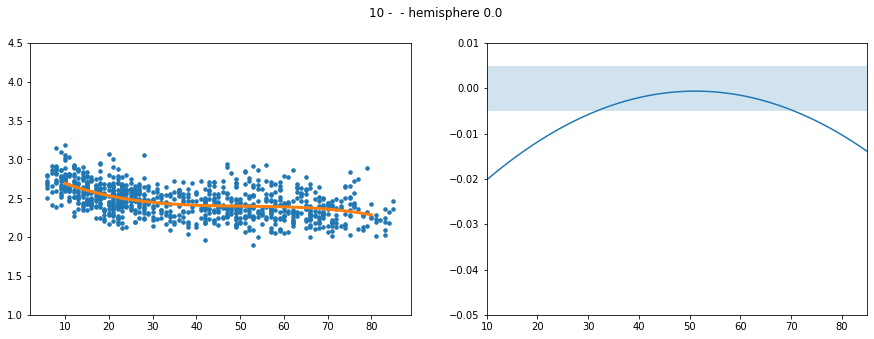

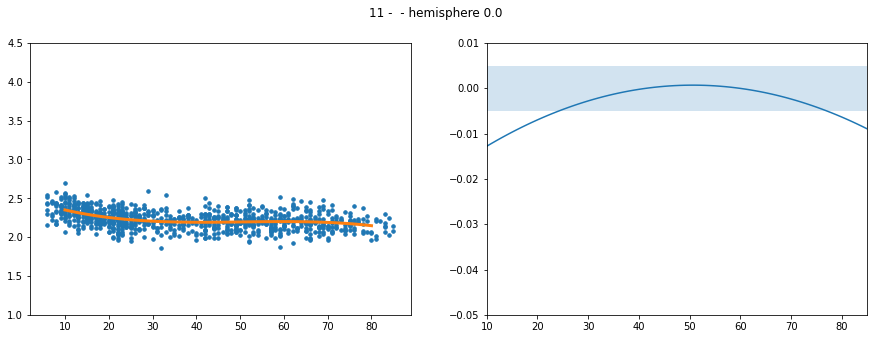

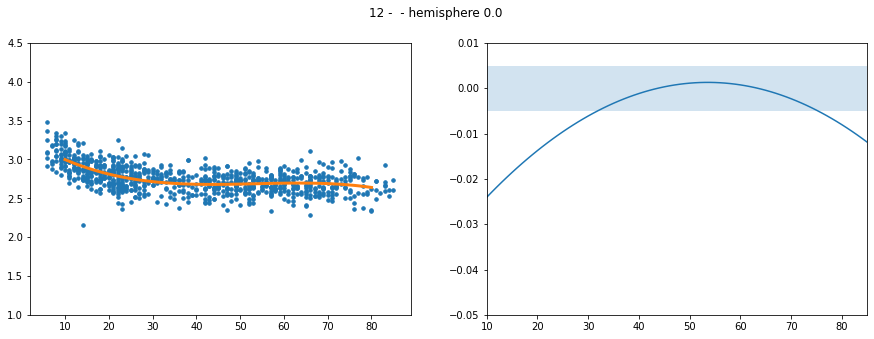

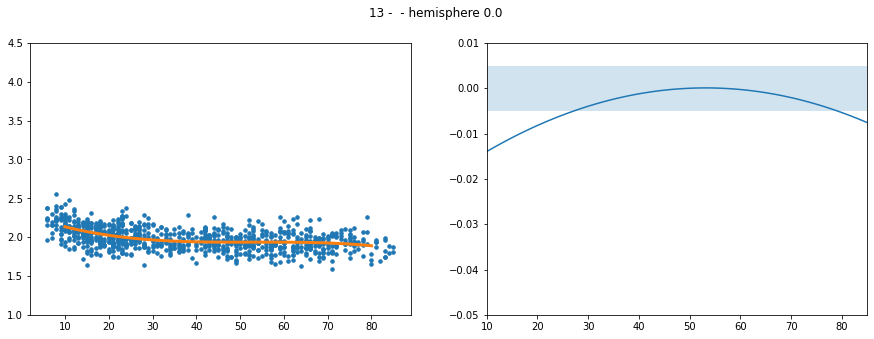

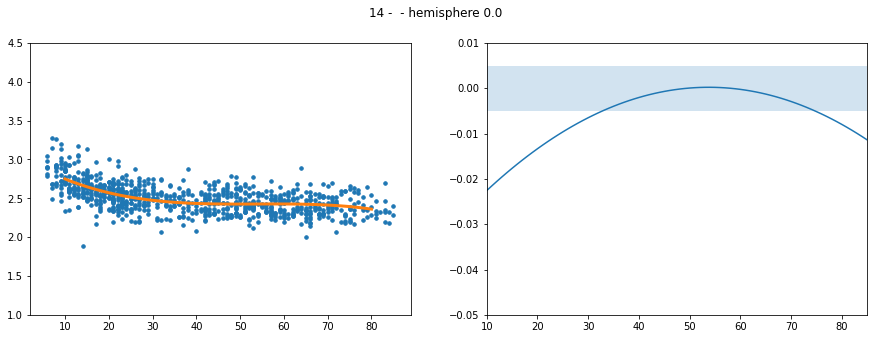

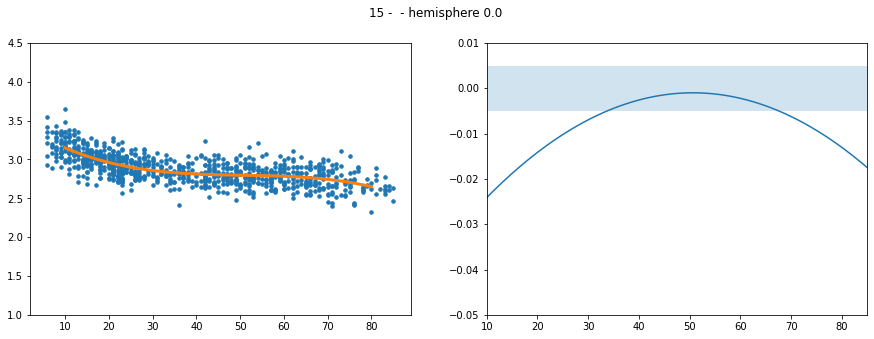

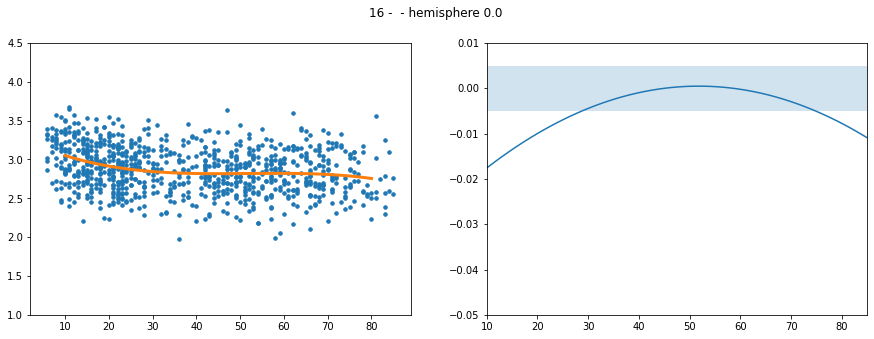

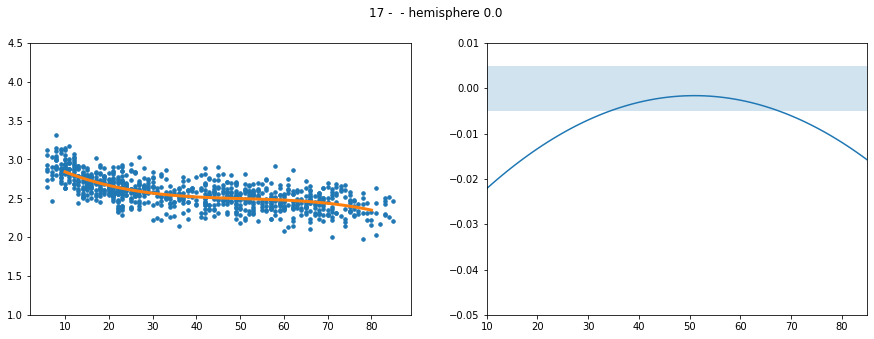

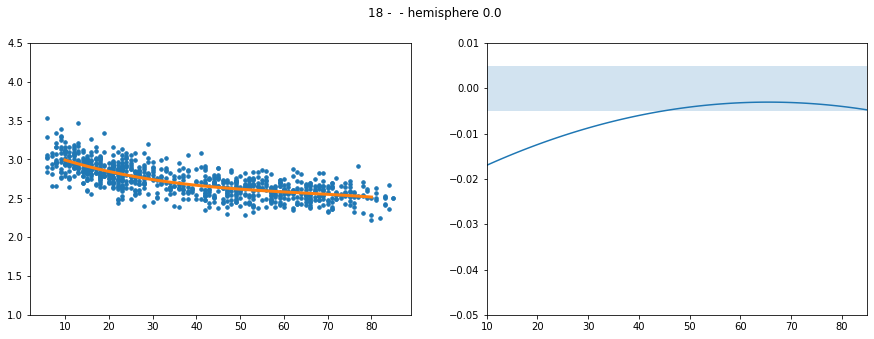

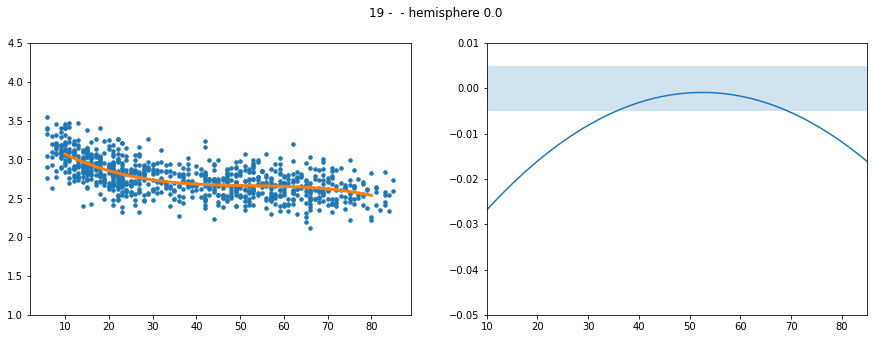

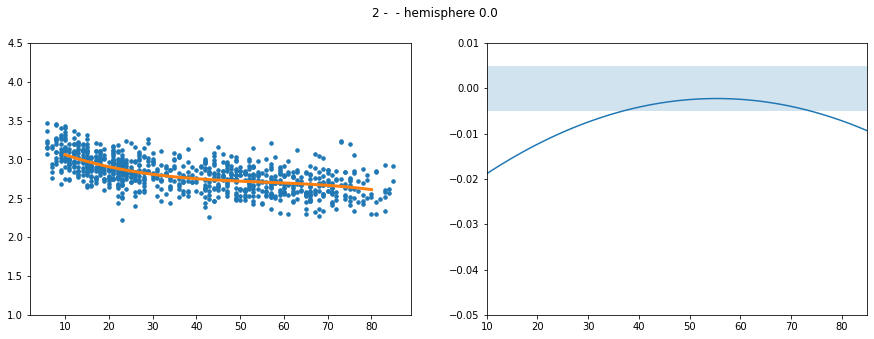

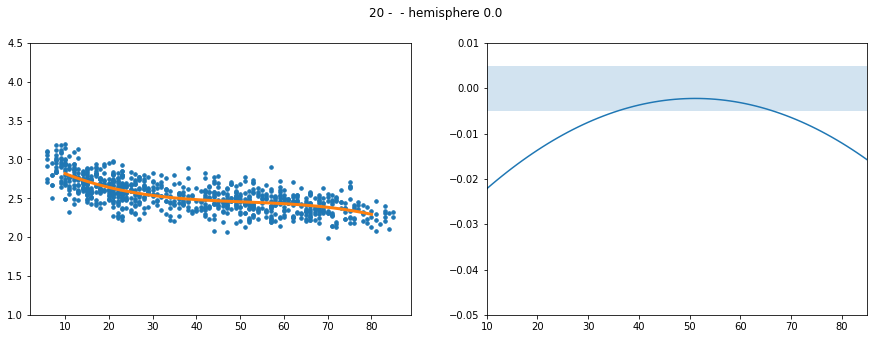

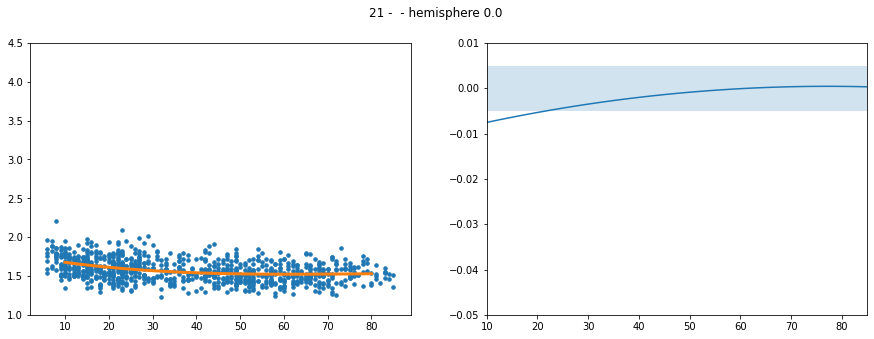

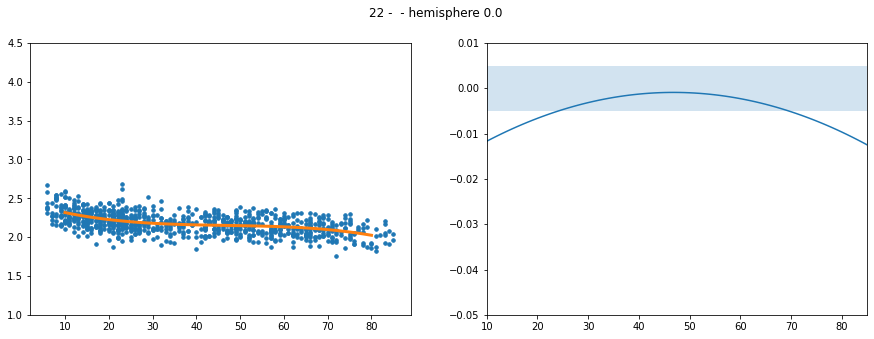

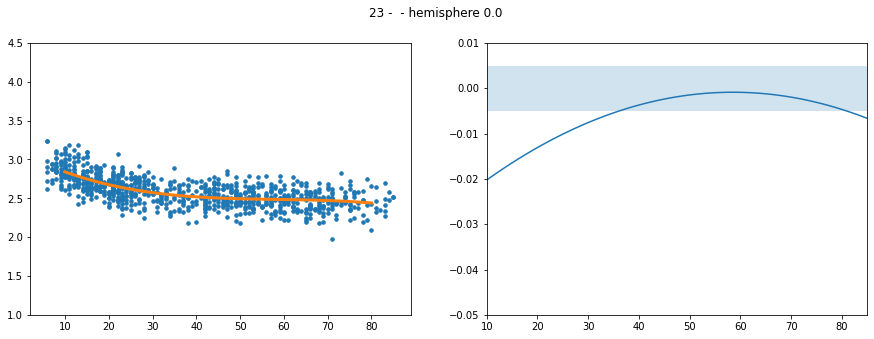

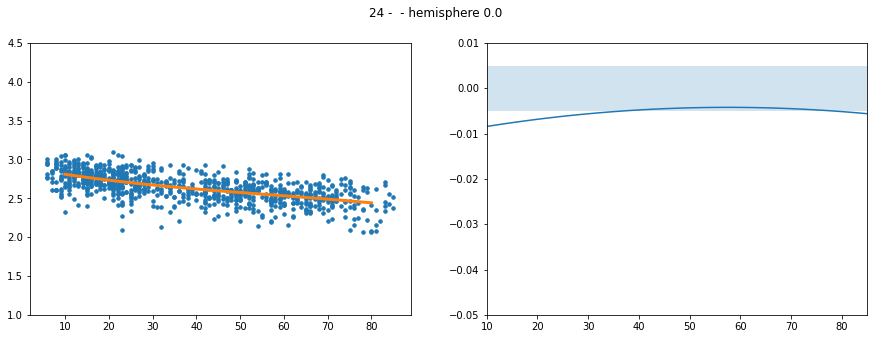

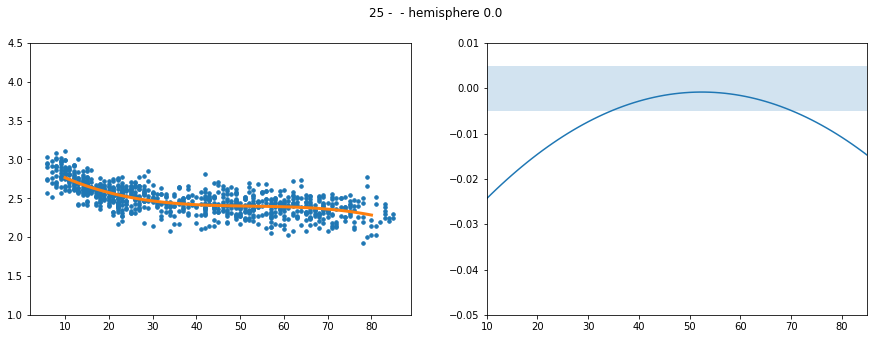

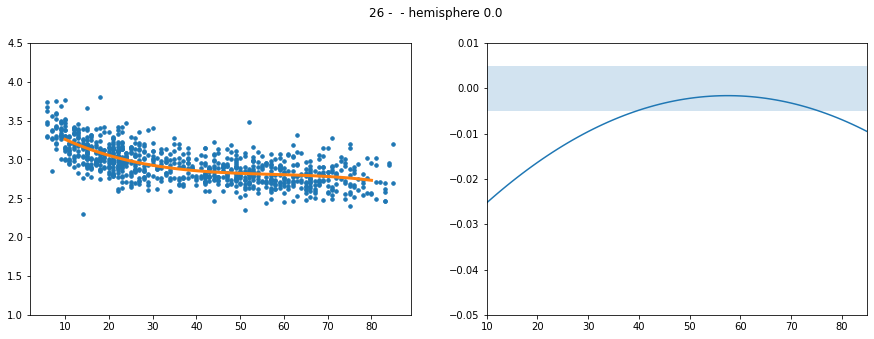

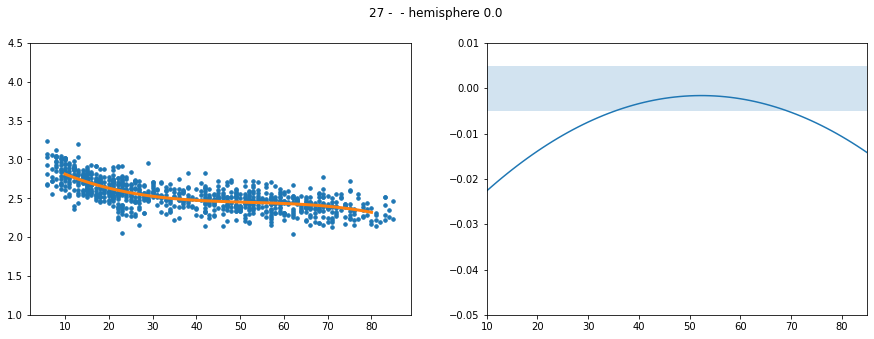

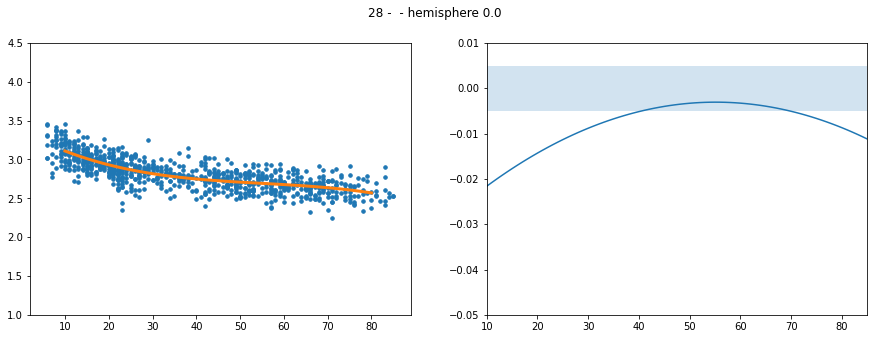

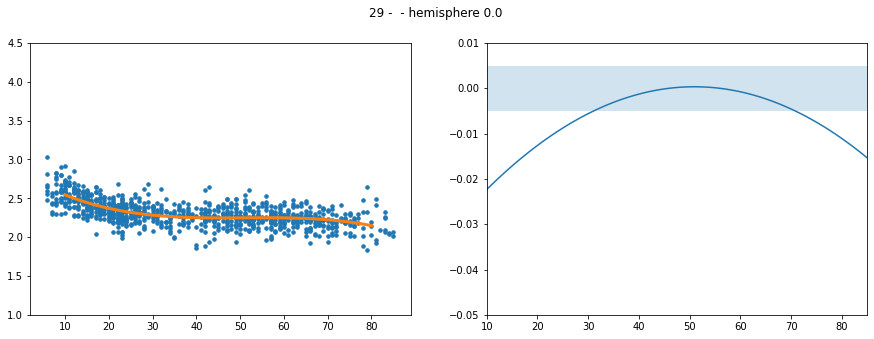

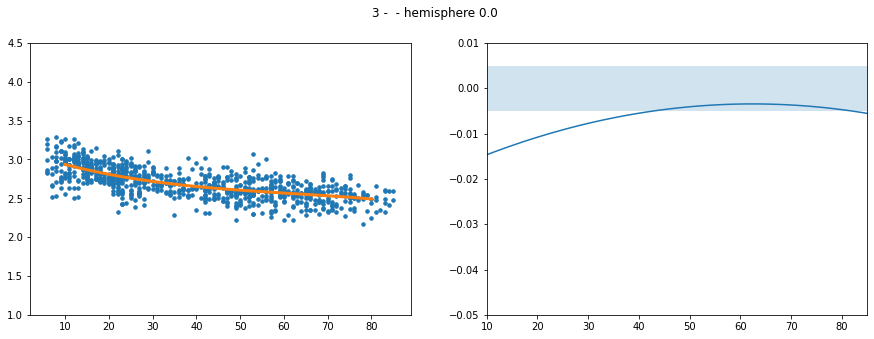

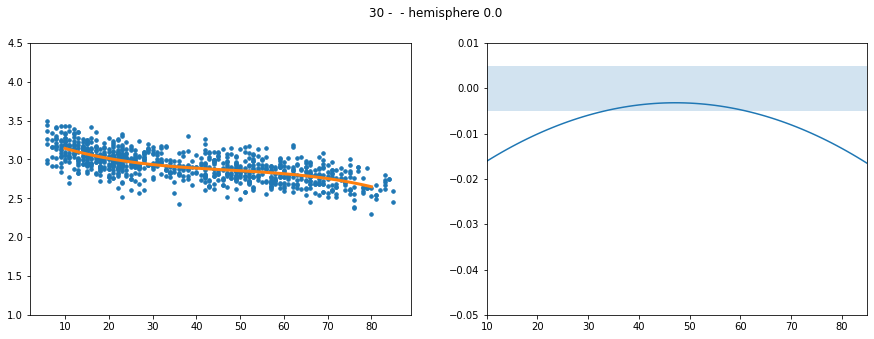

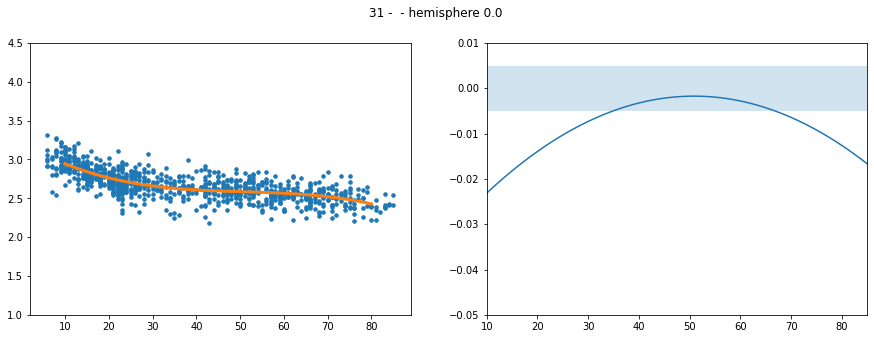

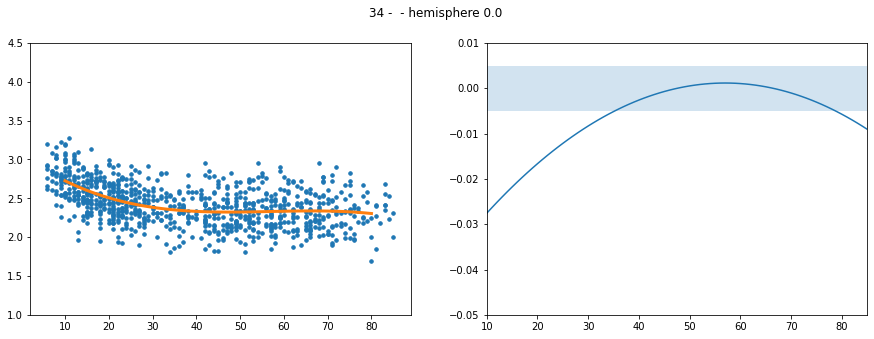

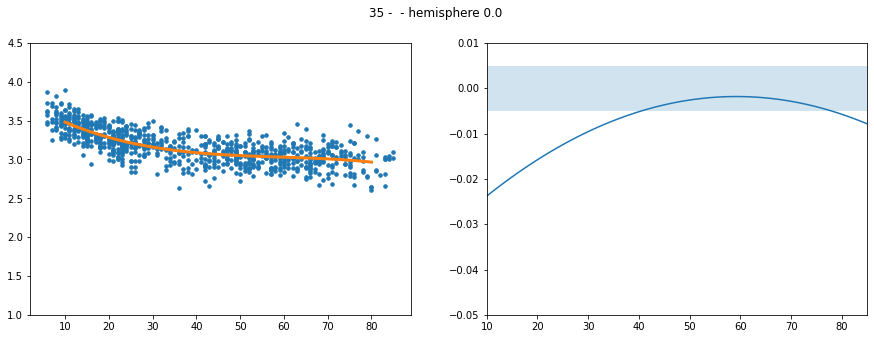

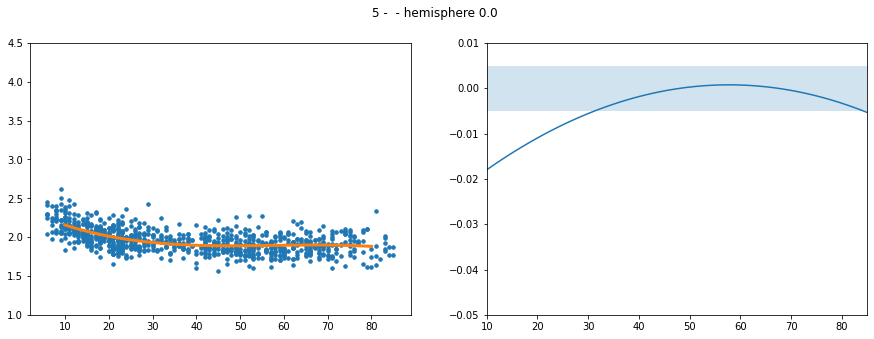

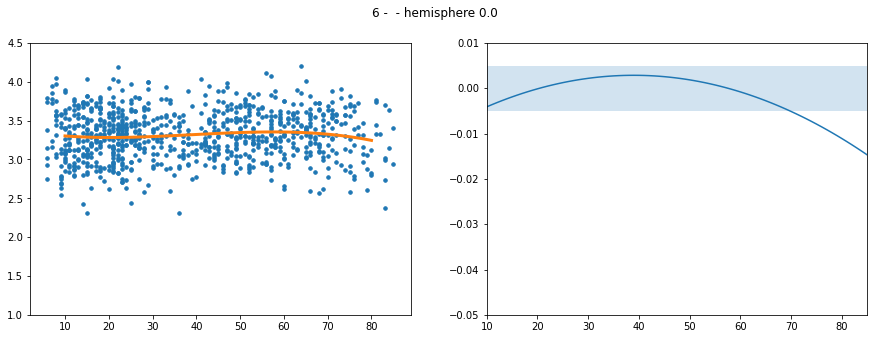

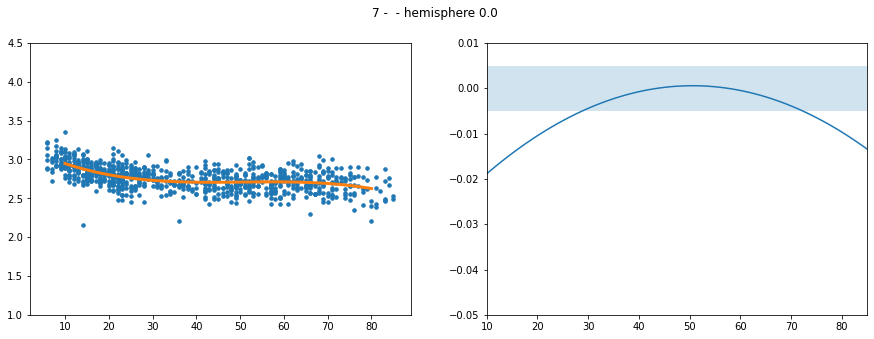

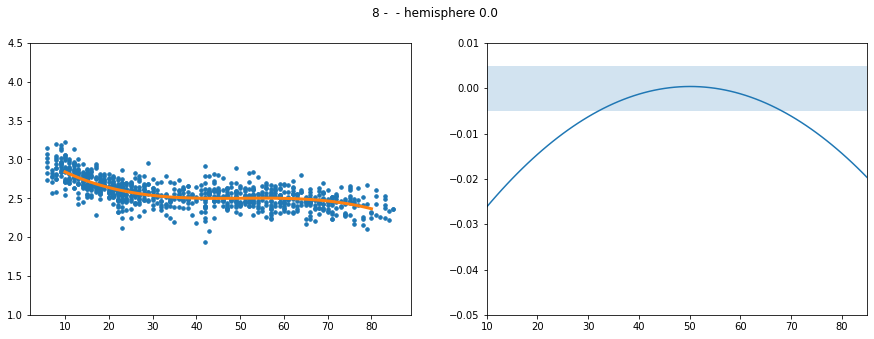

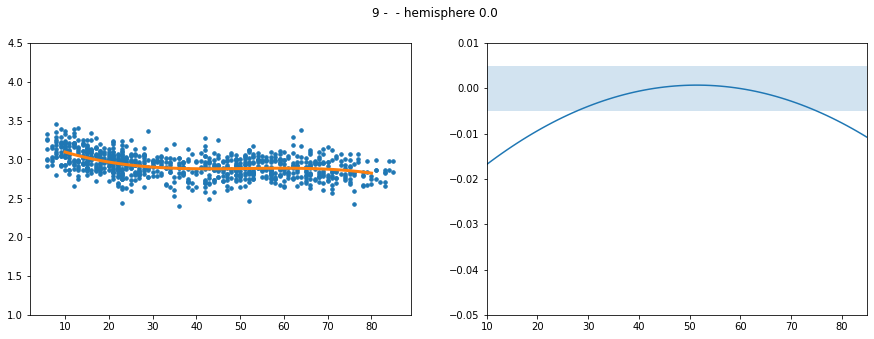

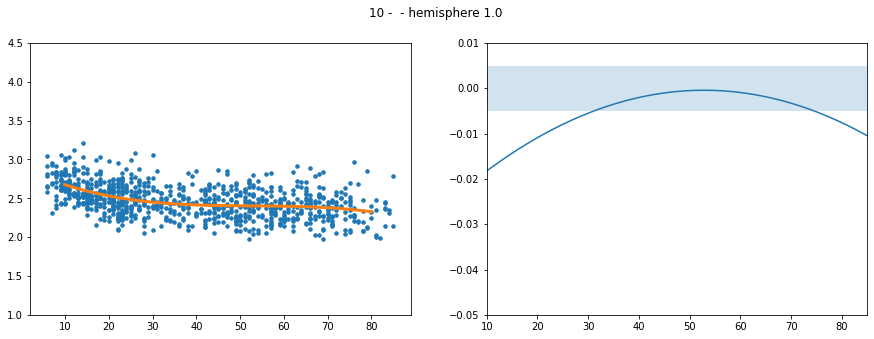

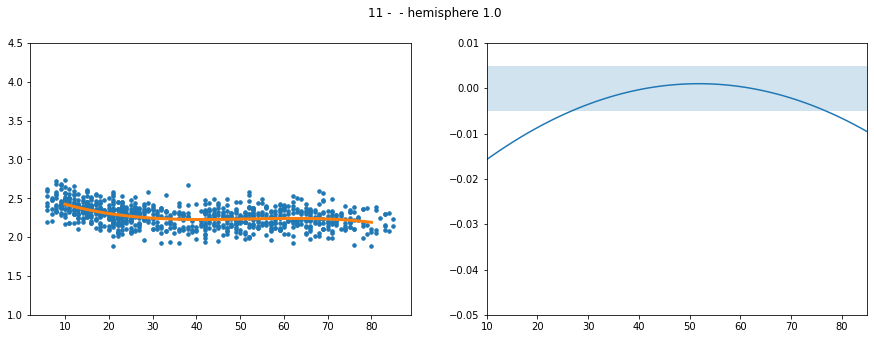

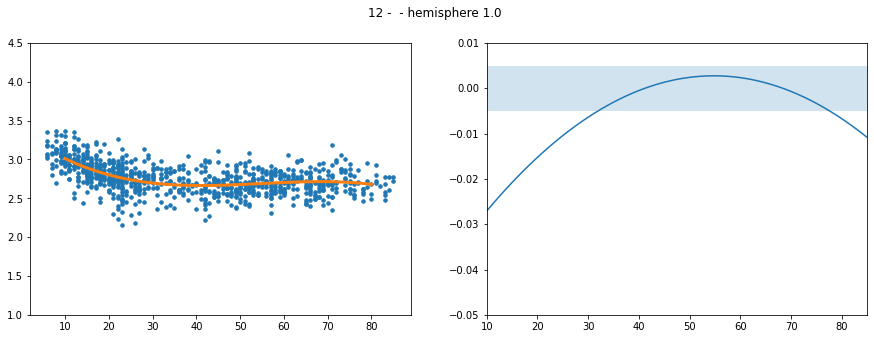

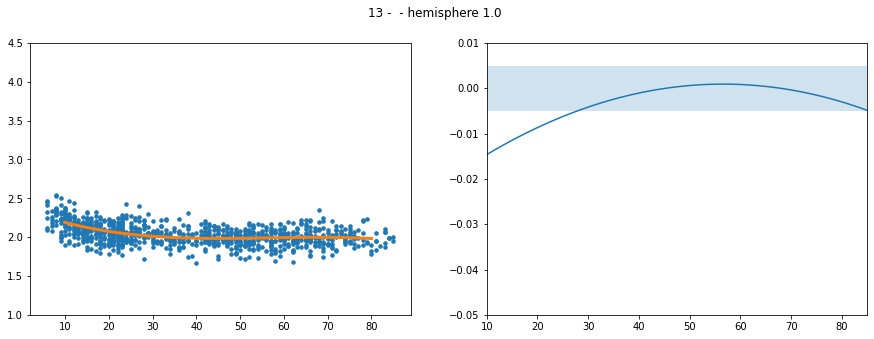

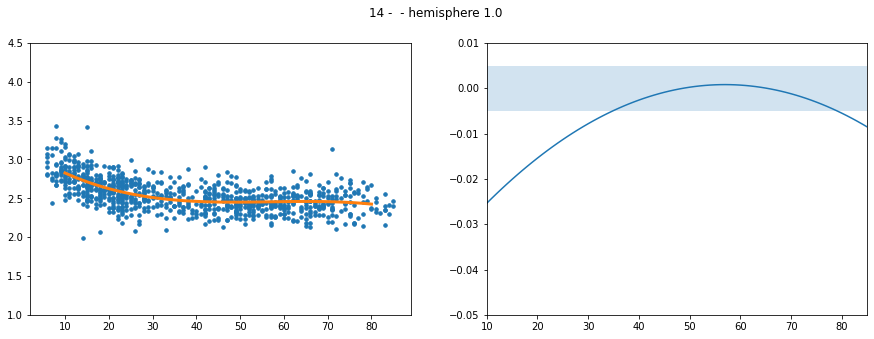

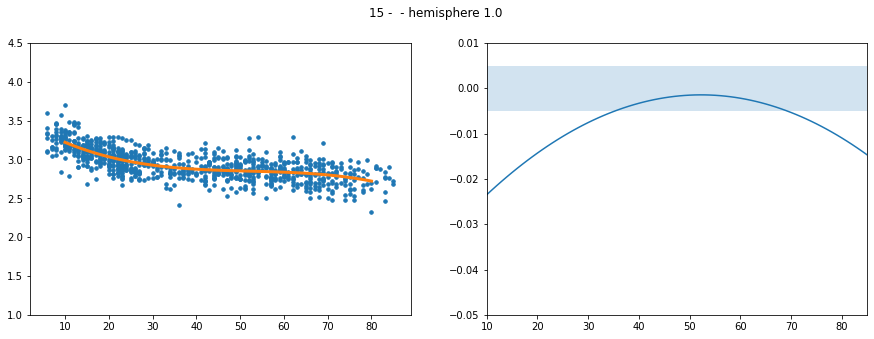

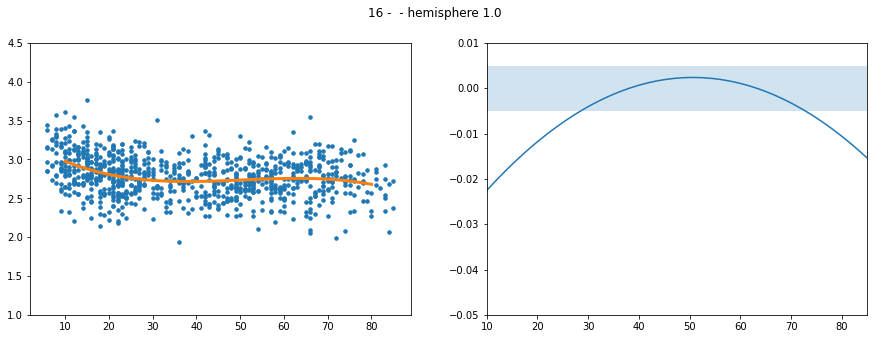

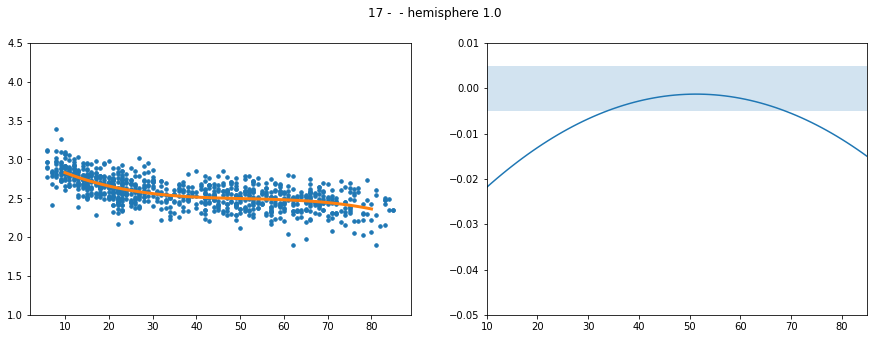

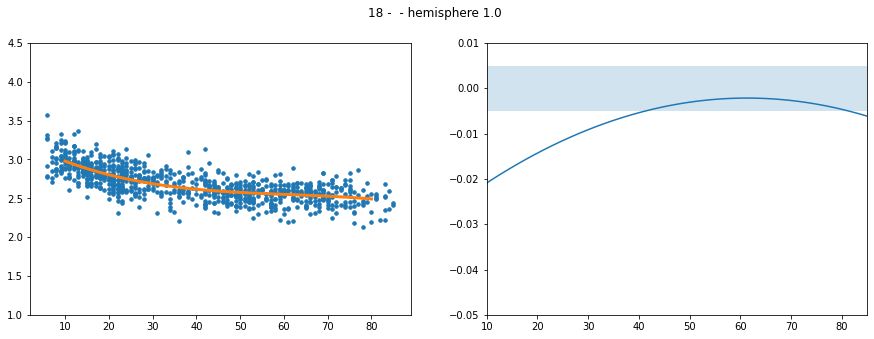

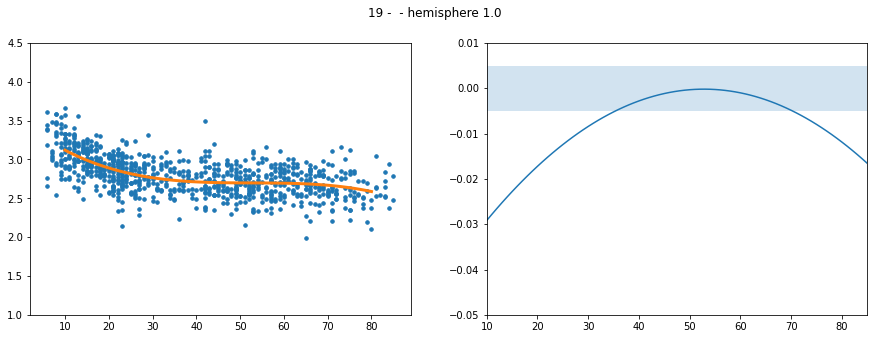

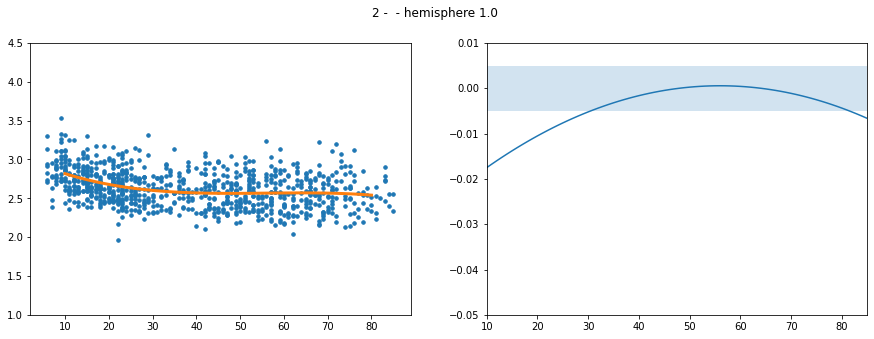

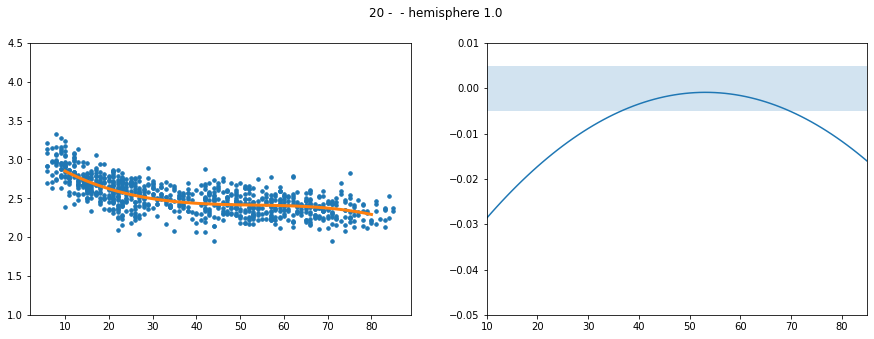

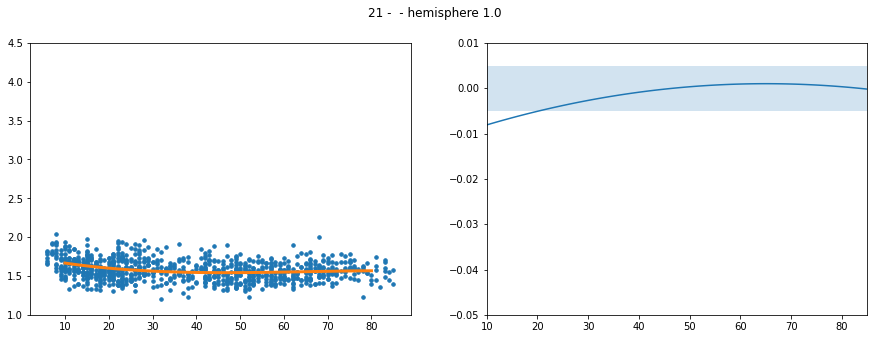

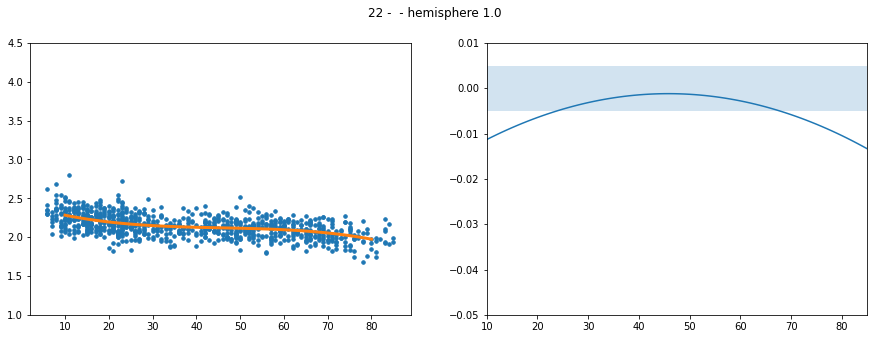

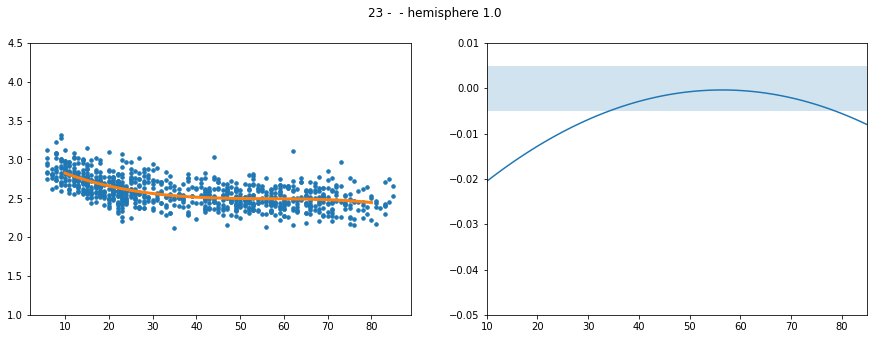

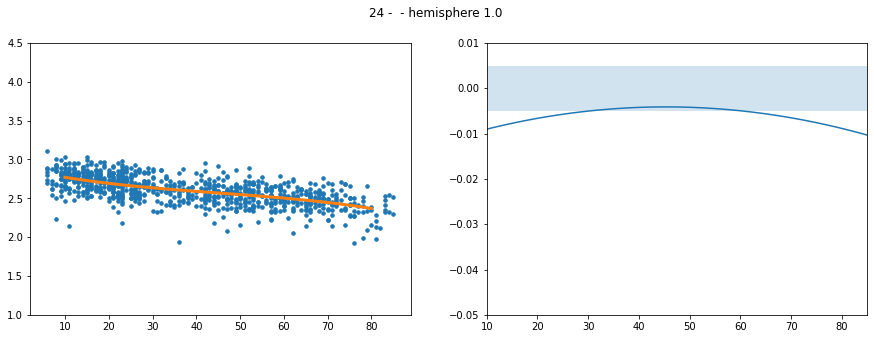

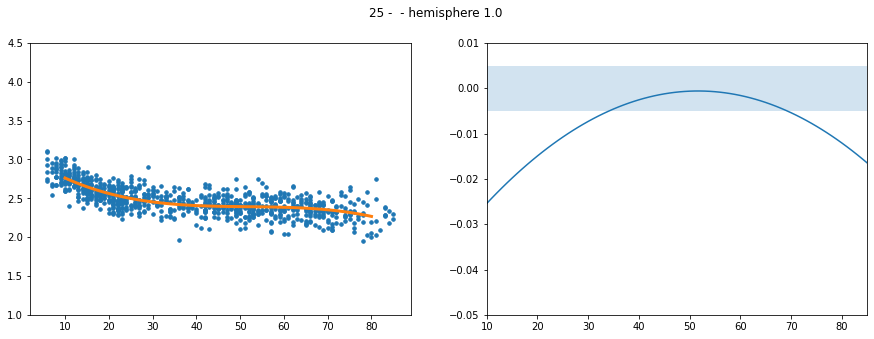

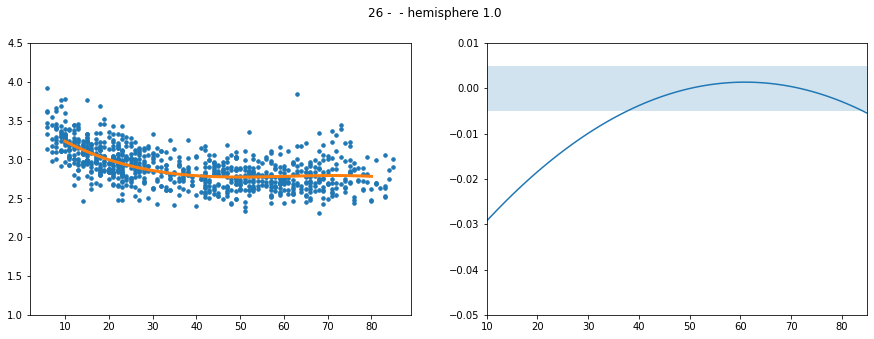

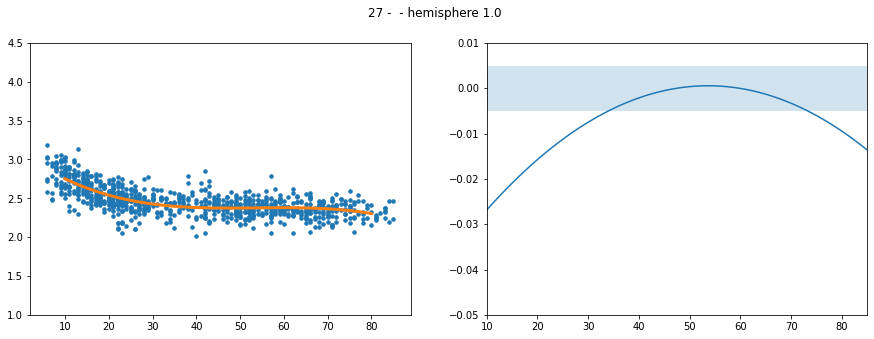

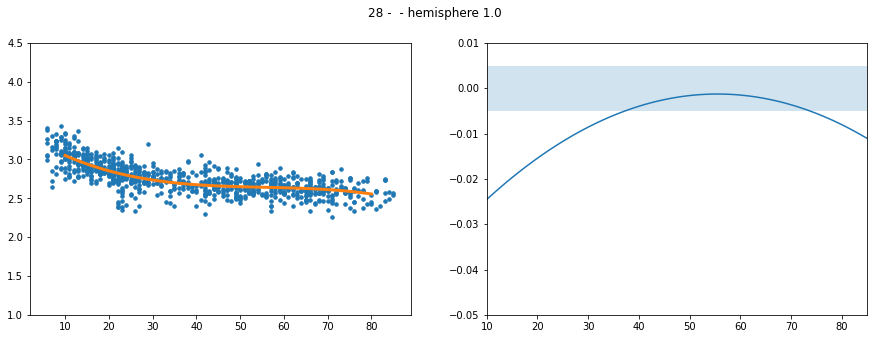

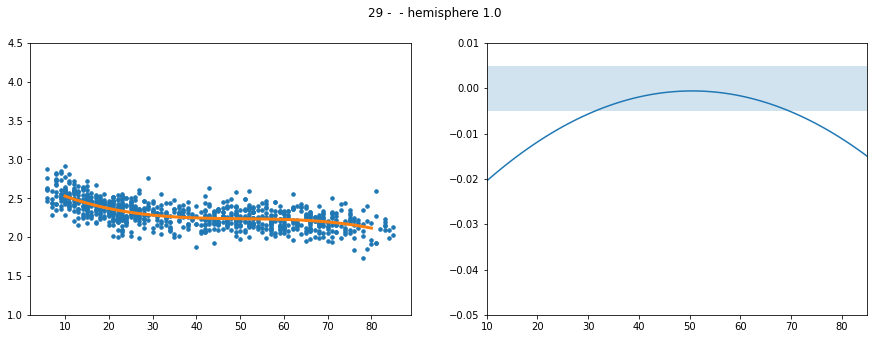

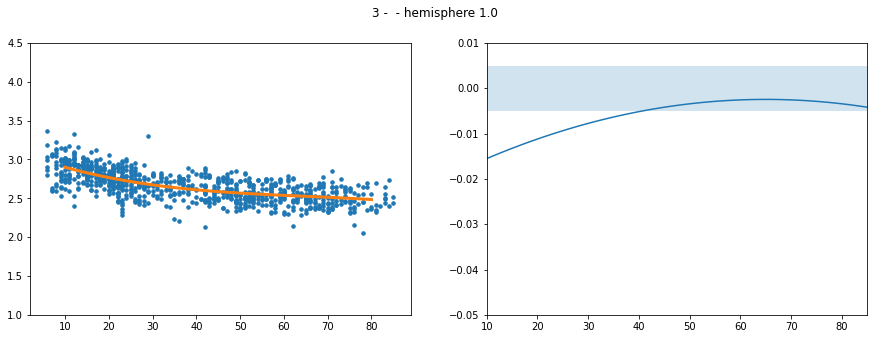

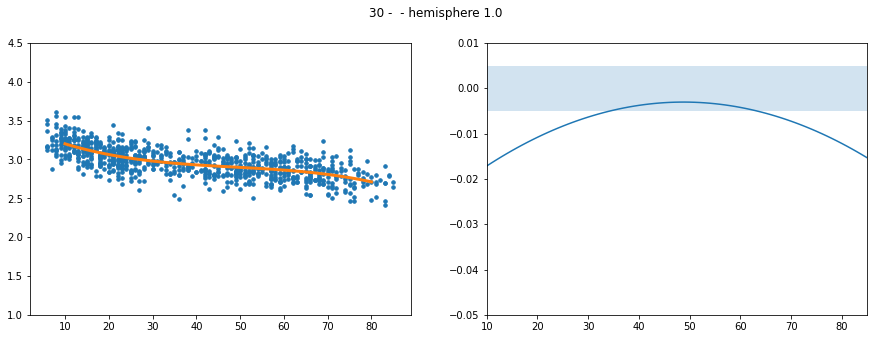

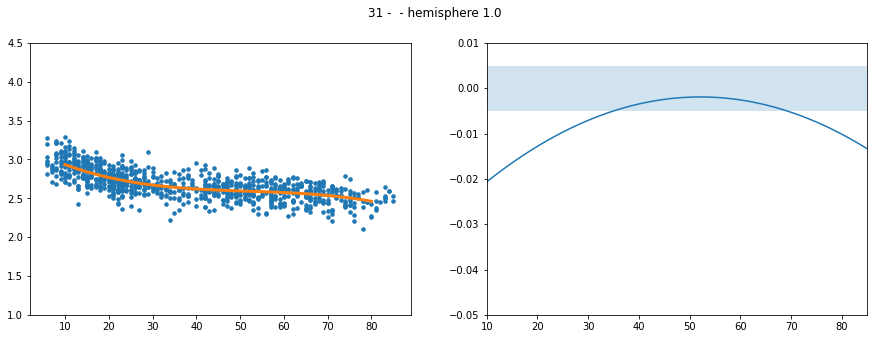

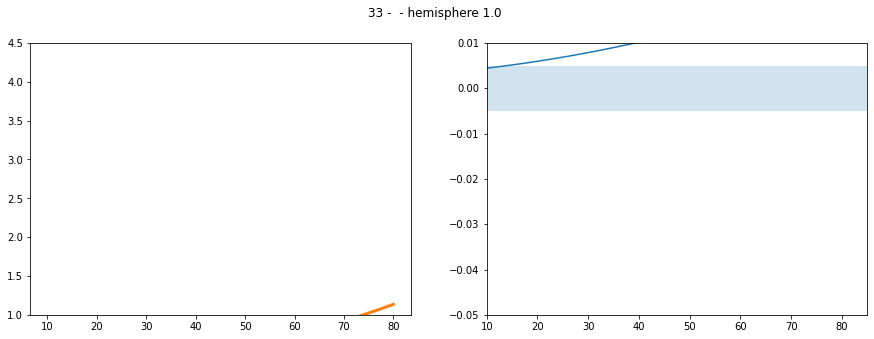

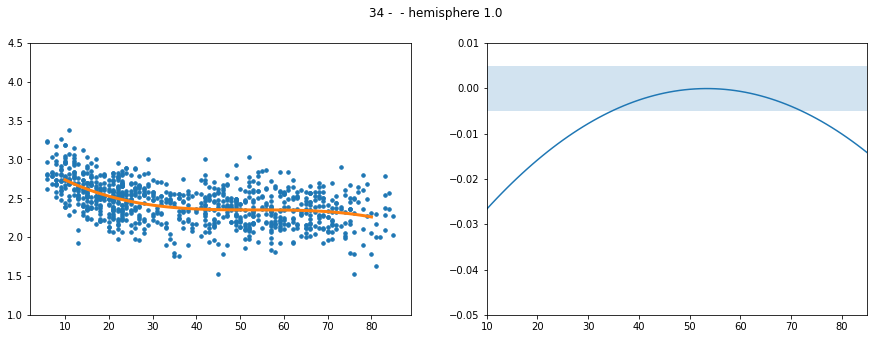

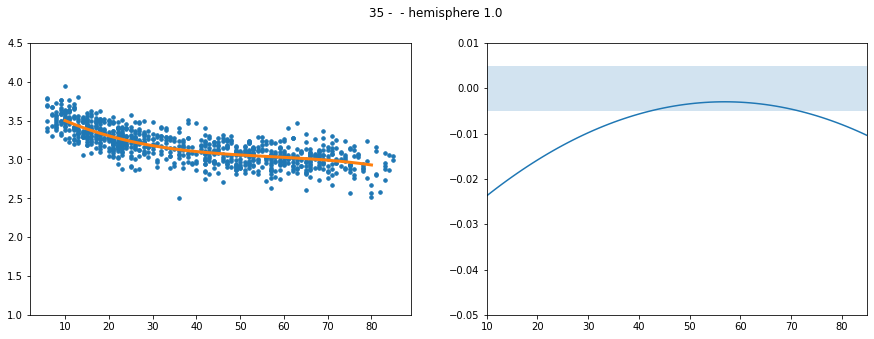

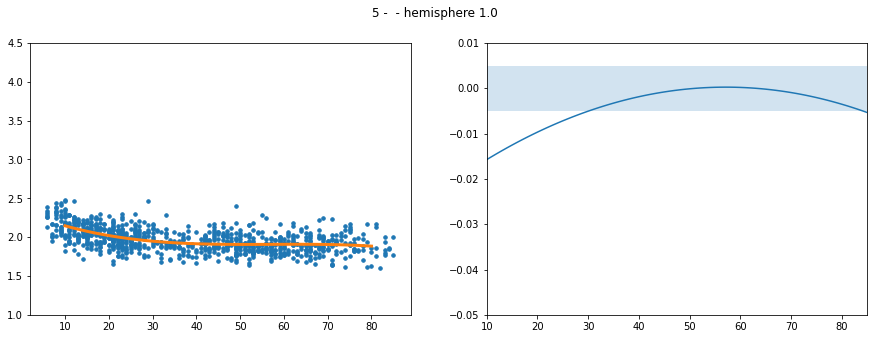

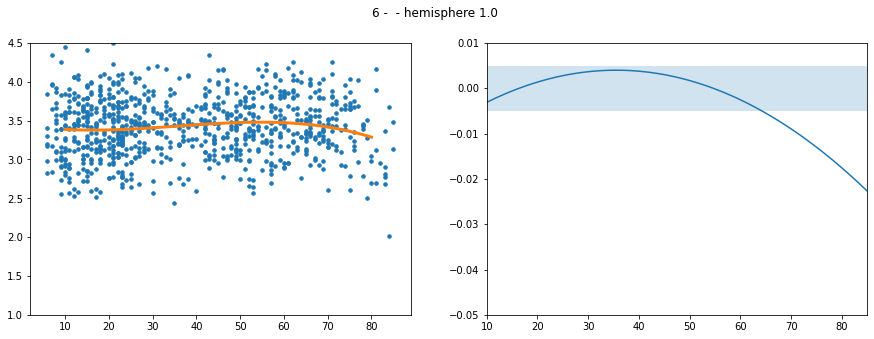

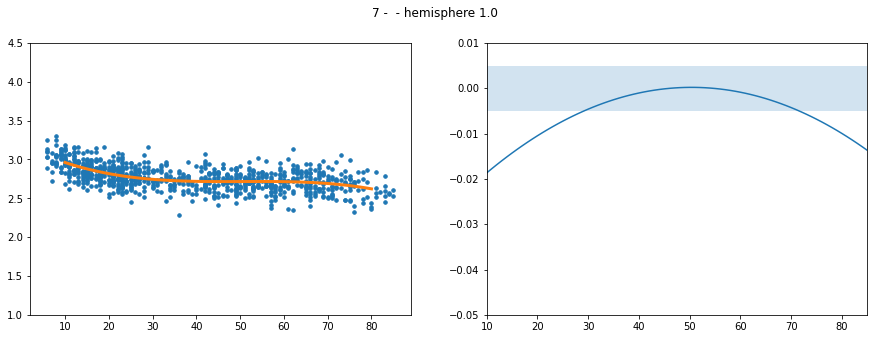

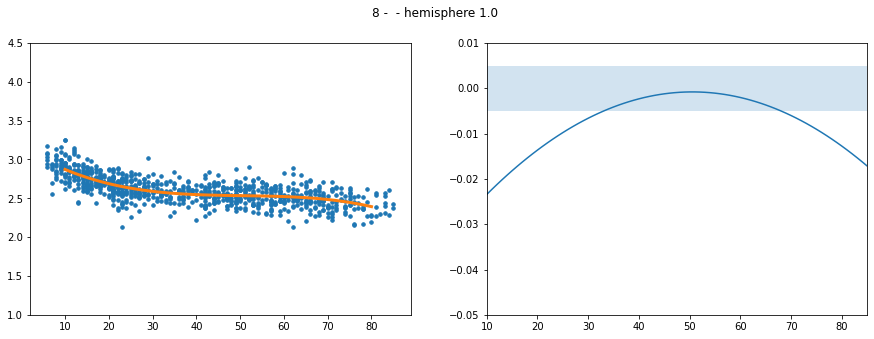

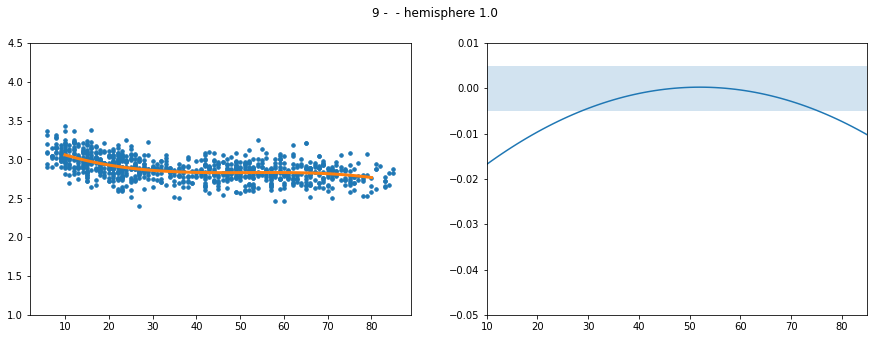

In [498]:
# ordenacao
h_structures = np.sort(df.h_structure.unique())


taxa_anual =[]
for h_structure in tqdm(h_structures):
    
    # variacao da espessura
    age = df[df.h_structure == h_structure].age
    thickness = df[df.h_structure == h_structure].thickness
    z = np.polyfit(age, thickness, 3)
    p = np.poly1d(z)
    xp = np.linspace(10, 80, 100)
    
    # variacao da variacao da espessura
    p2 = np.polyder(p)
    derivada = []
    for year in range(0, 100):
        derivada.append(p2(year))
    taxa_anual.append([h_structure]+ derivada)
    
    # plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    a = h_structure[1:]
    b = ' - '#+df[df.h_structure == h_structure].name.iloc[0] 
    c = ' - hemisphere '+ str(df[df.h_structure == h_structure].hemisphere.iloc[0])
    fig.suptitle(a+b+c)
    _ = ax1.plot(age, thickness, '.', xp, p(xp), '-', linewidth=3, markersize=7)
    ax1.axis(ymin=1,ymax=4.5)
    ax2.plot(derivada)
    ax2.axis(ymin=-0.05,ymax=0.01)
    ax2.axis(xmin=10,xmax=85)
    ax2.fill_between([10,85], 0.005, -0.005, alpha=.2)
    
taxa_anual = pd.DataFrame(taxa_anual)
taxa_anual = taxa_anual.rename(columns={0: "atlasDKT"})
taxa_anual.set_index('atlasDKT', inplace=True)

In [499]:
taxa_anual.head()

1         2         3         4         5         6  \
atlasDKT                                                               
010      -0.030900 -0.029727 -0.028577 -0.027450 -0.026347 -0.025267   
011      -0.020242 -0.019423 -0.018621 -0.017834 -0.017064 -0.016311   
012      -0.037021 -0.035603 -0.034212 -0.032848 -0.031510 -0.030199   
013      -0.021226 -0.020432 -0.019652 -0.018888 -0.018139 -0.017404   
014      -0.034183 -0.032914 -0.031670 -0.030449 -0.029253 -0.028080   

                 7         8         9        10        11        12  \
atlasDKT                                                               
010      -0.024209 -0.023175 -0.022165 -0.021177 -0.020213 -0.019271   
011      -0.015573 -0.014852 -0.014148 -0.013460 -0.012788 -0.012132   
012      -0.028915 -0.027658 -0.026427 -0.025223 -0.024046 -0.022896   
013      -0.016685 -0.015981 -0.015292 -0.014618 -0.013960 -0.013316   
014      -0.026931 -0.025805 -0.024704 -0.023626 -0.022572 -0.021542   

                13        14        15        16        17        18  \
atlasDKT                                                               
010      -0.018353 -0.017458 -0.016586 -0.015738 -0.014912 -0.014110   
011      -0.011493 -0.010870 -0.010263 -0.009673 -0.009099 -0.008542   
012      -0.021772 -0.020675 -0.019604 -0.018561 -0.017544 -0.016554   
013      -0.012688 -0.012074 -0.011476 -0.010892 -0.010324 -0.009771   
014      -0.020536 -0.019553 -0.018595 -0.017660 -0.016749 -0.015862   

                19        20        21        22        23        24  \
atlasDKT                                                               
010      -0.013331 -0.012575 -0.011843 -0.011133 -0.010447 -0.009784   
011      -0.008000 -0.007476 -0.006967 -0.006475 -0.005999 -0.005539   
012      -0.015590 -0.014653 -0.013743 -0.012860 -0.012003 -0.011173   
013      -0.009233 -0.008710 -0.008202 -0.007710 -0.007232 -0.006770   
014      -0.014998 -0.014159 -0.013343 -0.012551 -0.011783 -0.011038   

                25        26        27        28        29        30  \
atlasDKT                                                               
010      -0.009144 -0.008527 -0.007933 -0.007363 -0.006815 -0.006291   
011      -0.005096 -0.004669 -0.004259 -0.003865 -0.003487 -0.003125   
012      -0.010370 -0.009594 -0.008844 -0.008121 -0.007425 -0.006755   
013      -0.006322 -0.005890 -0.005473 -0.005071 -0.004683 -0.004312   
014      -0.010318 -0.009621 -0.008948 -0.008299 -0.007674 -0.007072   

                31        32        33        34        35        36  \
atlasDKT                                                               
010      -0.005790 -0.005313 -0.004858 -0.004427 -0.004018 -0.003633   
011      -0.002780 -0.002451 -0.002139 -0.001843 -0.001563 -0.001299   
012      -0.006112 -0.005496 -0.004906 -0.004344 -0.003808 -0.003298   
013      -0.003955 -0.003613 -0.003286 -0.002975 -0.002678 -0.002397   
014      -0.006495 -0.005941 -0.005411 -0.004905 -0.004422 -0.003964   

                37        38        39        40        41        42  \
atlasDKT                                                               
010      -0.003271 -0.002933 -0.002617 -0.002325 -0.002056 -0.001810   
011      -0.001052 -0.000821 -0.000607 -0.000409 -0.000227 -0.000061   
012      -0.002816 -0.002360 -0.001930 -0.001528 -0.001152 -0.000803   
013      -0.002131 -0.001879 -0.001643 -0.001422 -0.001216 -0.001026   
014      -0.003529 -0.003118 -0.002731 -0.002367 -0.002028 -0.001712   

                43        44        45        46        47        48  \
atlasDKT                                                               
010      -0.001587 -0.001387 -0.001211 -0.001057 -0.000927 -0.000820   
011       0.000088  0.000221  0.000337  0.000437  0.000521  0.000588   
012      -0.000481 -0.000185  0.000084  0.000326  0.000541  0.000730   
013      -0.000850 -0.000689 -0.000544 -0.000413 -0.000298 -0.000198   
014      -0.001420 -0.001152 -0.000908 -0.000687 -

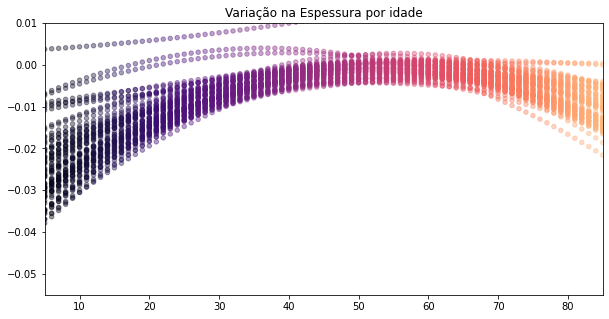

In [500]:
# Referencia
plt.figure(figsize=(10,5))
plt.title('Variação na Espessura por idade')
for i in range(len(taxa_anual)):
    plt.scatter(taxa_anual.columns, taxa_anual.iloc[i], alpha=0.4, c=taxa_anual.columns, cmap=plt.cm.magma, s=20)
    plt.xlim(5,85)
    plt.ylim(-0.055,0.01)
plt.show()

-------------------

## 2. Modelagem para prever variação de espessura anual

#### 2.1. DataSet

In [533]:
def rate(h_structure, age):
    return taxa_anual.loc[h_structure, age]

# add anual rate
df1 = df.copy()
df1['anual_rate'] = df1.apply(lambda x: rate(x.h_structure, x.age), axis=1)

# add initial thickness (at 10 years)
thickness10 = df1[df1.age == 10][['h_structure', 'thickness']].groupby(['h_structure']).mean()
thickness10 = thickness10.rename(columns={'thickness':'thickness10'})
df1 = df1.merge(thickness10, on='h_structure')

# uni os dados de cada idade
dfs = []
for h_structure in df.h_structure.unique():
    df0 = df1[df1.h_structure == h_structure].groupby(['age']).mean()
    df0['h_structure'] = h_structure
    dfs.append(df0.reset_index())

df1 = pd.concat(dfs).reset_index(drop=True)

# check sum layers thickness
df1['thickness_layer_1'] = df1.thickness * df1.bigbrain_layer_1
df1['thickness_layer_2'] = df1.thickness * df1.bigbrain_layer_2
df1['thickness_layer_3'] = df1.thickness * df1.bigbrain_layer_3
df1['thickness_layer_4'] = df1.thickness * df1.bigbrain_layer_4
df1['thickness_layer_5'] = df1.thickness * df1.bigbrain_layer_5
df1['thickness_layer_6'] = df1.thickness * df1.bigbrain_layer_6
df1['sum_thickness_layers'] = df1['thickness_layer_1']+ df1['thickness_layer_2']+df1['thickness_layer_3']+df1['thickness_layer_4']+df1['thickness_layer_5']+df1['thickness_layer_6']
df1[['sum_thickness_layers', 'thickness']]

# rename
df1.rename(columns= {'hemisphere':'Hemisphere',
                     'sex':'Gender', 
                     'age':'Age',
                     'lobe':'Lobe',
                     'thickness_layer_1': 'Layer I thickness',
                     'thickness_layer_2': 'Layer II thickness',
                     'thickness_layer_3': 'Layer III thickness',
                     'thickness_layer_4': 'Layer IV thickness',
                     'thickness_layer_5': 'Layer V thickness',
                     'thickness_layer_6': 'Layer VI thickness',
                     'thickness10':'Thickness at 10y.o.',
                     'sulc':'Curvature'
                     
                       }, inplace=True)


# show
df1.head()

Age    Gender  handedness  Hemisphere  atlasDF      area      curv  \
0   6.0  0.714286    1.857143         0.0     10.0  0.655077 -0.027693   
1   7.0  0.000000    1.666667         0.0     10.0  0.646284 -0.028095   
2   8.0  0.333333    1.666667         0.0     10.0  0.652489 -0.024335   
3   9.0  0.357143    1.642857         0.0     10.0  0.647904 -0.021873   
4  10.0  0.500000    1.833333         0.0     10.0  0.645049 -0.019936   

   Curvature  thickness  bigbrain_layer_1  bigbrain_layer_2  bigbrain_layer_3  \
0  -0.111188   2.688395          0.108929          0.086125          0.280021   
1  -0.342735   2.710835          0.109105          0.085927          0.279501   
2  -0.139919   2.791334          0.108496          0.086202          0.280989   
3  -0.168052   2.704111          0.108857          0.085912          0.279355   
4  -0.040541   2.794945          0.108566          0.086038          0.279964   

   bigbrain_layer_4  bigbrain_layer_5  bigbrain_layer_6  Lobe  anual_rate  \
0          0.097536          0.207798          0.219592   5.0   -0.025267   
1          0.098815          0.207318          0.219334   5.0   -0.024209   
2          0.093905          0.209544          0.220863   5.0   -0.023175   
3          0.099071          0.207251          0.219554   5.0   -0.022165   
4          0.097067          0.208156          0.220209   5.0   -0.021177   

   Thickness at 10y.o. h_structure  Layer I thickness  Layer II thickness  \
0             2.794945         010           0.292843            0.231538   
1             2.794945         010           0.295767            0.232935   
2             2.794945         010           0.302849            0.240619   
3             2.794945         010           0.294362            0.232316   
4             2.794945         010           0.303435            0.240472   

   Layer III thickness  Layer IV thickness  Layer V thickness  \
0             0.752807            0.262214           0.558642   
1             0.757680            0.267870           0.562005   
2             0.784335            0.262121           0.584908   
3             0.755407            0.267899           0.560429   
4             0.782485            0.271296           0.581785   

   Layer VI thickness  sum_thickness_layers  
0            0.590351              2.688395  
1            0.594578              2.710835  
2            0.616503              2.791334  
3            0.593699              2.704111  
4            0.615472              2.794945

In [534]:
df1.columns

Index(['Age', 'Gender', 'handedness', 'Hemisphere', 'atlasDF', 'area', 'curv',
       'Curvature', 'thickness', 'bigbrain_layer_1', 'bigbrain_layer_2',
       'bigbrain_layer_3', 'bigbrain_layer_4', 'bigbrain_layer_5',
       'bigbrain_layer_6', 'Lobe', 'anual_rate', 'Thickness at 10y.o.',
       'h_structure', 'Layer I thickness', 'Layer II thickness',
       'Layer III thickness', 'Layer IV thickness', 'Layer V thickness',
       'Layer VI thickness', 'sum_thickness_layers'],
      dtype='object')

#### 2.2. Feature Analyses and Selection

In [573]:
features_sets = [['Age'],
                 
                 ['Age','Thickness at 10y.o.', 
                  'Curvature', 
                  'Hemisphere', 'Gender',
                  'Lobe', 
                  'Layer I thickness','Layer II thickness','Layer III thickness',
                  'Layer IV thickness','Layer V thickness','Layer VI thickness'],
                 
                 ['Thickness at 10y.o.', 
                  'Curvature', 
                  'Hemisphere', 'Gender',
                  'Lobe', 
                  'Layer I thickness','Layer II thickness','Layer III thickness',
                  'Layer IV thickness','Layer V thickness','Layer VI thickness'],
                 
                ]


#### 2.4. Model Training and Testing

In [574]:
inexplicable_strutures = {}
for key in pd.Series([x[1:] for x in df1.h_structure.unique()]).unique():
    inexplicable_strutures[key]=0
    
list_performance = []
testes = []
shap_info = []
lgbm_dict_list = []
X_train_dict_list = []

for features in tqdm(features_sets):    

    X = df1[features]
    y = df1.anual_rate
    performance = []
    lgbm_dict = {}
    X_train_dict = {}
    shap_values_ = {}
    expected_value = {}
    
    for i, struture in enumerate(set([x[1:] for x in df1.h_structure.unique()])):

        # Train Test Split
        test_index = df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index
        train_index = set(df1.index)-set(test_index)
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
        
        # Model Train
        lgbm_dict[i] = LGBMRegressor()
        lgbm_dict[i].fit(X_train, y_train) #, categorical_feature = categorical_feature #fode o modelo usar categoricas
        
        # Model Test
        y_pred = lgbm_dict[i].predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        # SHAP
        X_train_dict[i] = X_train
        
        # Save Performance
        performance.append([struture,r2])
    
    # Save SHAP
    shap_info.append([[features], shap_values_, X_train_dict, expected_value])
    lgbm_dict_list.append(lgbm_dict)
    X_train_dict_list.append(X_train_dict)
    
    # Ajust and save to List of all Performance
    performance = pd.DataFrame(performance).sort_values(by=1, ascending=False)
    performance.columns = ['struture','r2']#+features
    performance['features'] = [features]*len(performance)
    list_performance.append(performance)
    
    # Handling Inexplicable strutures
    for key in performance[performance.r2<0].struture:
        inexplicable_strutures[key]=inexplicable_strutures[key]+1
    testes.append([features, performance.mean()[1], performance[performance.r2>0].mean()[1], len(performance[performance.r2<0])])
    
# Finishing
testes = pd.DataFrame(testes).rename(columns={0:'features',1:'r2_all',2:'r2_clean',3:'inexplicable_strutures'})

100%|██████████| 3/3 [00:29<00:00,  9.86s/it]


#### 2.4. Model Evaluation

In [575]:
testes

features    r2_all  r2_clean  \
0                                              [Age]  0.299335  0.837576   
1  [Age, Thickness at 10y.o., Curvature, Hemisphe...  0.372507  0.871531   
2  [Thickness at 10y.o., Curvature, Hemisphere, G... -1.056736  0.598879   

   inexplicable_strutures  
0                       4  
1                       4  
2                       6

In [576]:
model = 2
list_performance[model]

struture         r2                                           features
24       28   0.877176  [Thickness at 10y.o., Curvature, Hemisphere, G...
23       17   0.812643  [Thickness at 10y.o., Curvature, Hemisphere, G...
29        3   0.796350  [Thickness at 10y.o., Curvature, Hemisphere, G...
10       18   0.778034  [Thickness at 10y.o., Curvature, Hemisphere, G...
5        25   0.758375  [Thickness at 10y.o., Curvature, Hemisphere, G...
26       23   0.758149  [Thickness at 10y.o., Curvature, Hemisphere, G...
13       15   0.756069  [Thickness at 10y.o., Curvature, Hemisphere, G...
2        27   0.717343  [Thickness at 10y.o., Curvature, Hemisphere, G...
11       19   0.708625  [Thickness at 10y.o., Curvature, Hemisphere, G...
27       26   0.706678  [Thickness at 10y.o., Curvature, Hemisphere, G...
30       14   0.694616  [Thickness at 10y.o., Curvature, Hemisphere, G...
28       31   0.685468  [Thickness at 10y.o., Curvature, Hemisphere, G...
19        7   0.669887  [Thickness at 10y.o., Curvature, Hemisphere, G...
17       10   0.668168  [Thickness at 10y.o., Curvature, Hemisphere, G...
21       20   0.632766  [Thickness at 10y.o., Curvature, Hemisphere, G...
9         5   0.526373  [Thickness at 10y.o., Curvature, Hemisphere, G...
16        9   0.489378  [Thickness at 10y.o., Curvature, Hemisphere, G...
4        13   0.469000  [Thickness at 10y.o., Curvature, Hemisphere, G...
14       34   0.457991  [Thickness at 10y.o., Curvature, Hemisphere, G...
0        30   0.395106  [Thickness at 10y.o., Curvature, Hemisphere, G...
8         2   0.394129  [Thickness at 10y.o., Curvature, Hemisphere, G...
15        8   0.391659  [Thickness at 10y.o., Curvature, Hemisphere, G...
25       12   0.361975  [Thickness at 10y.o., Curvature, Hemisphere, G...
18       29   0.284819  [Thickness at 10y.o., Curvature, Hemisphere, G...
7        22   0.181195  [Thickness at 10y.o., Curvature, Hemisphere, G...
3        21  -0.320443  [Thickness at 10y.o., Curvature, Hemisphere, G...
20       16  -0.372380  [Thickness at 10y.o., Curvature, Hemisphere, G...
1        35  -0.645242  [Thickness at 10y.o., Curvature, Hemisphere, G...
12       11  -1.120197  [Thickness at 10y.o., Curvature, Hemisphere, G...
6         6 -10.206719  [Thickness at 10y.o., Curvature, Hemisphere, G...
22       24 -35.065797  [Thickness at 10y.o., Curvature, Hemisphere, G...

In [577]:
explicables = list_performance[model][list_performance[model].r2 >0].struture
explicables_index = explicables.index.tolist()
explicables = [int(x) for x in explicables.tolist()]

inexplicables = list_performance[model][list_performance[model].r2 <0].struture
inexplicables = [int(x) for x in inexplicables.tolist()]
inexplicables

[21, 16, 35, 11, 6, 24]

In [578]:
pd.concat(list_performance, axis=0).mean().sort_values()

r2          -1.282978e-01
struture    1.153681e+162
dtype: float64

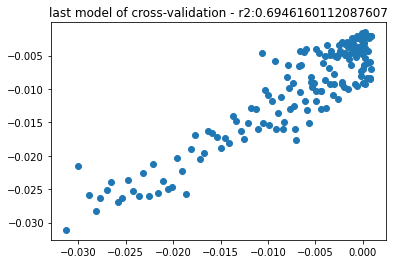

(0.0037658415258729054, 2.091028546714615e-05, 11.025303992874925)

In [579]:
plt.title('last model of cross-validation - r2:'+str(r2))
plt.scatter(y_test, y_pred)
plt.show()
mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)

#### 2.5 Final Model

In [580]:
# Take inexplicables
atlas = 'atlasDF' #'atlasEcono'
df1_ = df1[df1[atlas].isin(explicables)] 
print(len(df1[atlas].unique()))
print(len(df1_[atlas].unique()))

# Final Model
X = df1_[features_sets[1]]
y = df1_.anual_rate
lgbm = LGBMRegressor()
lgbm.fit(X, y)

31
25


LGBMRegressor()

## 3. Explicabilidade

#### 3.1 Explicando Modelo Final 

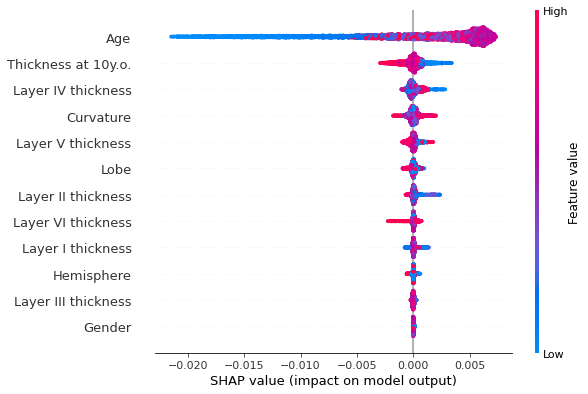

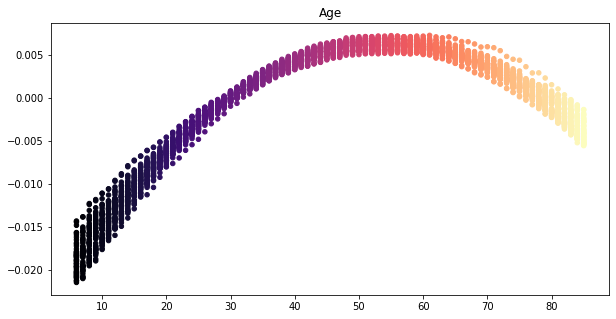

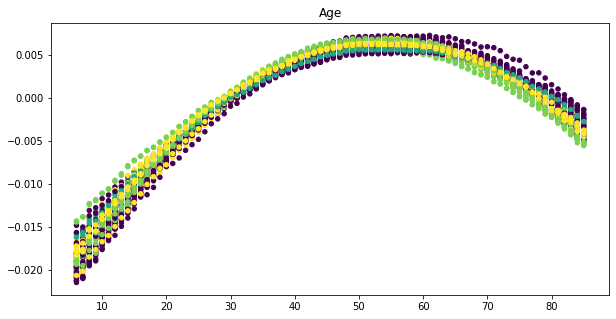

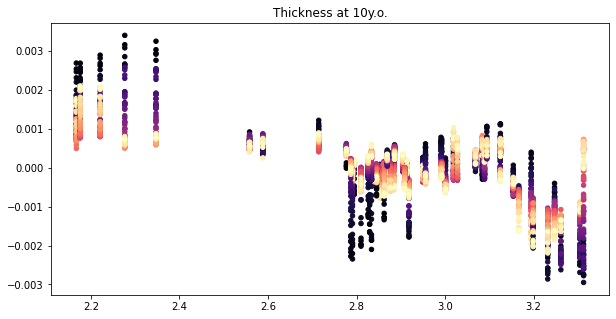

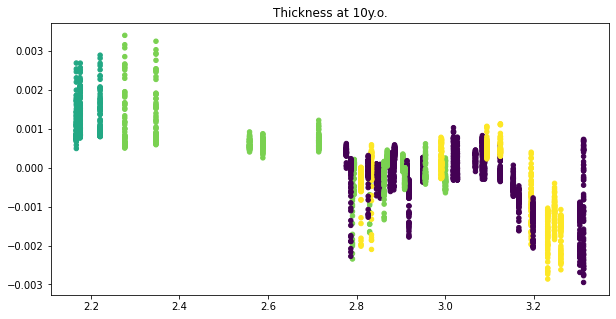

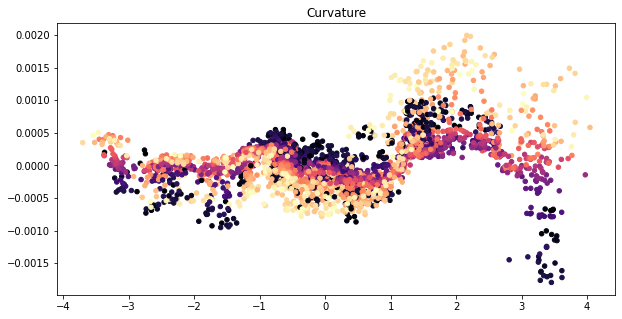

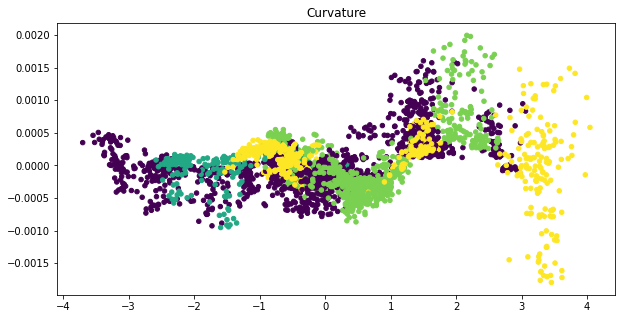

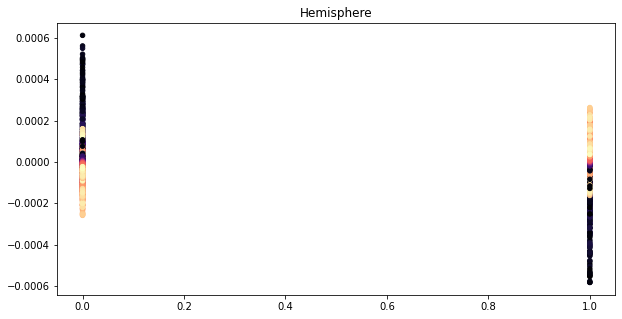

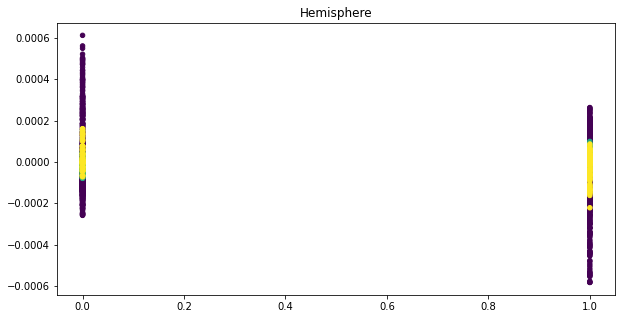

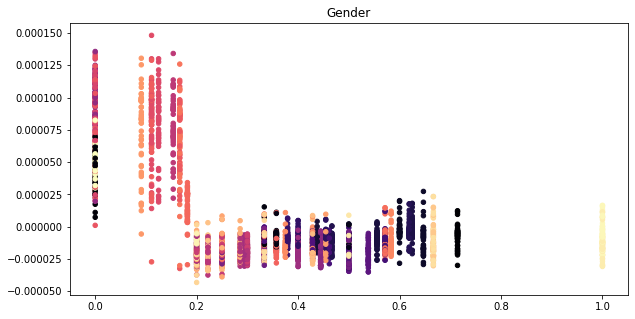

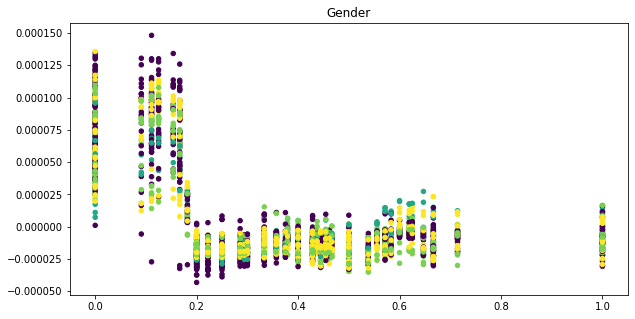

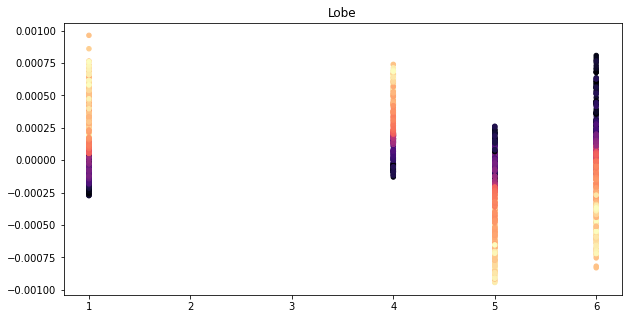

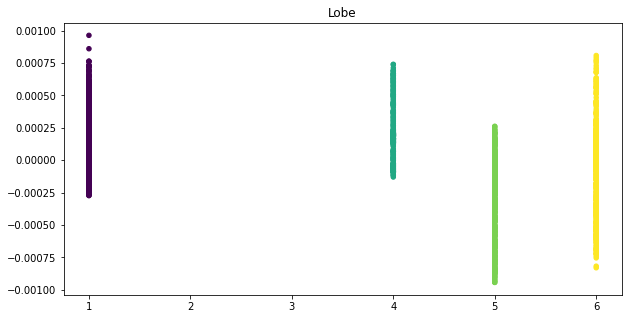

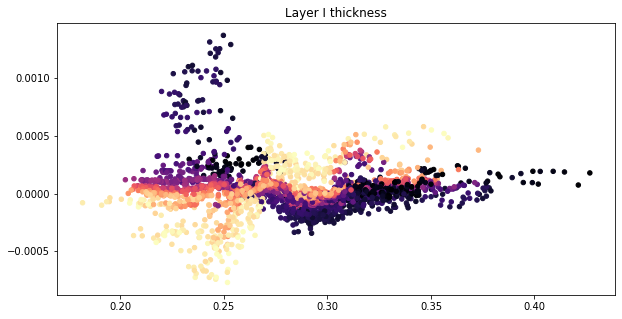

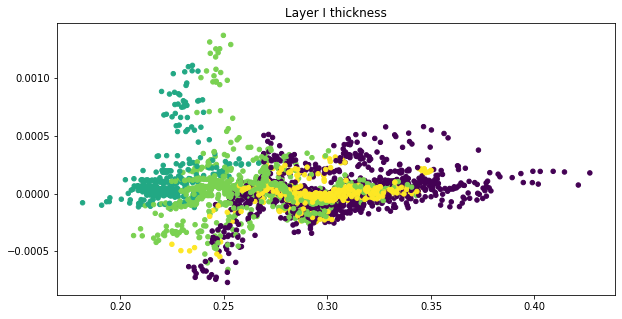

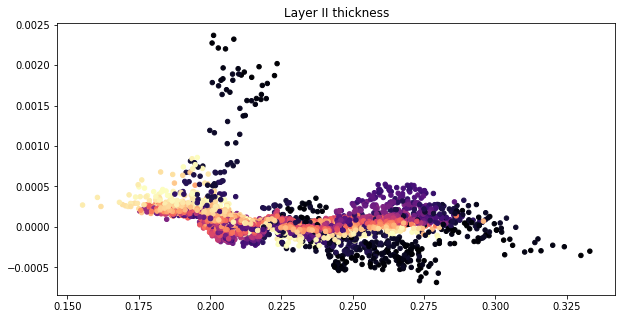

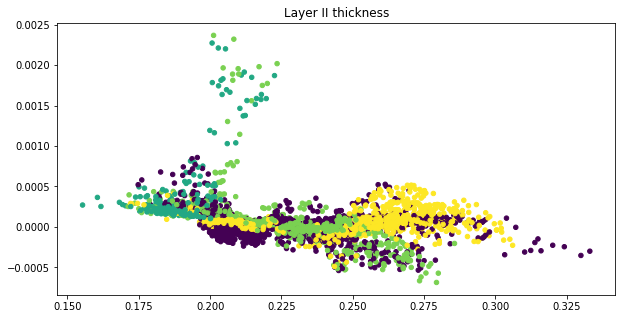

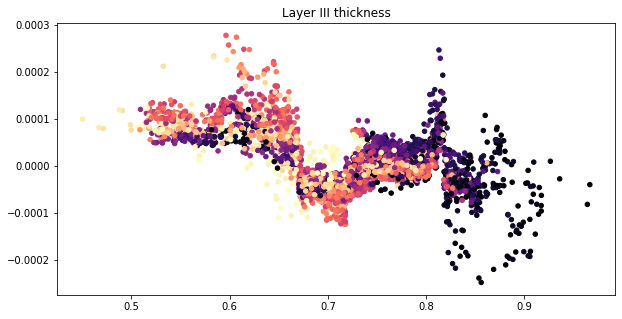

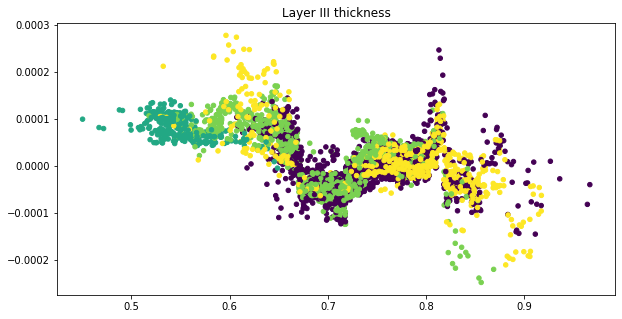

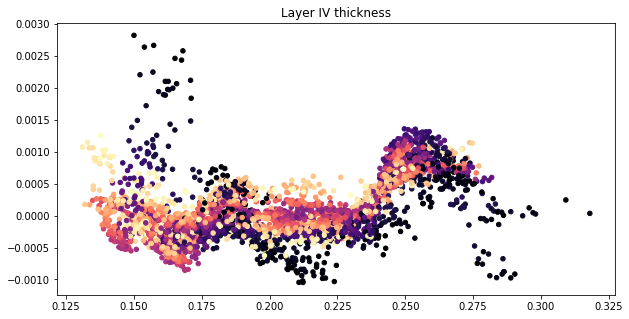

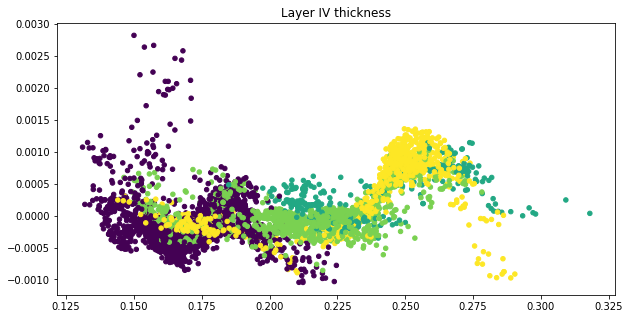

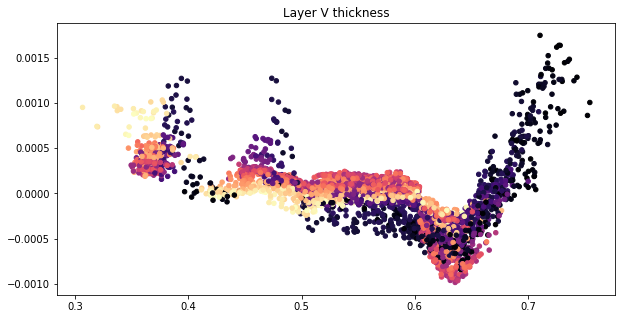

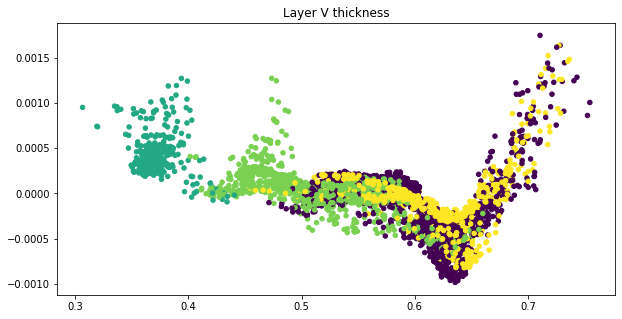

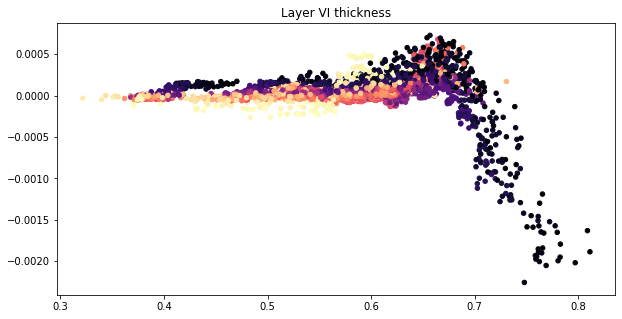

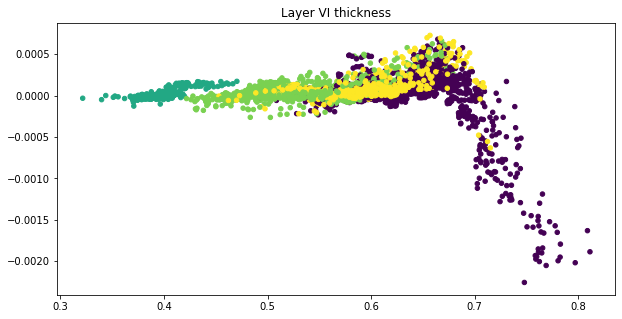

In [581]:
explainer = shap.Explainer(lgbm)
shap_info = explainer(X)

shap.summary_plot(shap_info)

for i in range(len(X.columns)):
    plt.figure(figsize=(10,5))
    plt.title(str(X.columns[i]))
    plt.scatter(shap_info.data[:,i], shap_info.values[:,i], alpha=1, c=X.Age, cmap=plt.cm.magma, s=20)
    plt.show()
    plt.figure(figsize=(10,5))
    plt.title(str(X.columns[i]))
    plt.scatter(shap_info.data[:,i], shap_info.values[:,i], alpha=1, c=X.Lobe, cmap=plt.cm.viridis, s=20)
    plt.show()

In [582]:
boost = lgbm.booster_
df_tree = boost.trees_to_dataframe()
df_tree.head()
#create_tree_digraph(lgbm,show_info = ['split_gain','data_percentage'], precision=6, tree_index=99)

tree_index  node_depth node_index left_child right_child parent_index  \
0           0           1       0-S0       0-S1        0-S2         None   
1           0           2       0-S1       0-S4        0-S6         0-S0   
2           0           3       0-S4       0-L0        0-S7         0-S1   
3           0           4       0-L0       None        None         0-S4   
4           0           4       0-S7      0-S13       0-S19         0-S4   

         split_feature  split_gain  threshold decision_type missing_direction  \
0                  Age    0.137312   23.50000            <=              left   
1                  Age    0.013775   13.50000            <=              left   
2  Thickness_at_10y.o.    0.003036    2.45262            <=              left   
3                 None         NaN        NaN          None              None   
4                  Age    0.001457    9.50000            <=              left   

  missing_type     value  weight  count  
0         None -0.007474       0   4000  
1         None -0.008561     900    900  
2         None -0.008999     400    400  
3         None -0.008253      48     48  
4         None -0.009101     352    352

#### 3.2 Explicando Modelos Cross-Validation 

100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


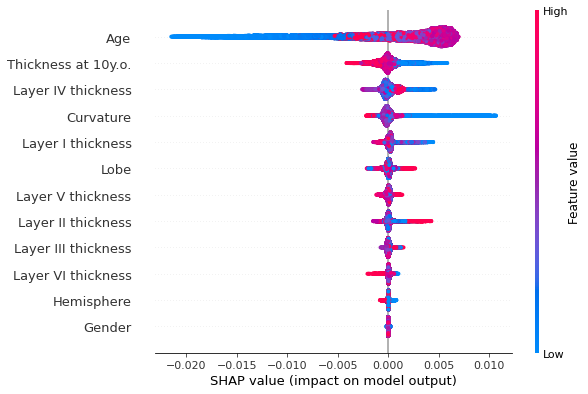

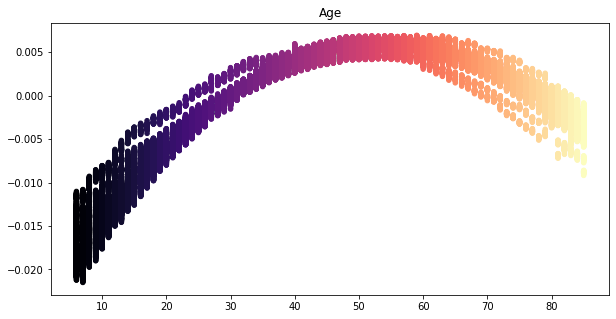

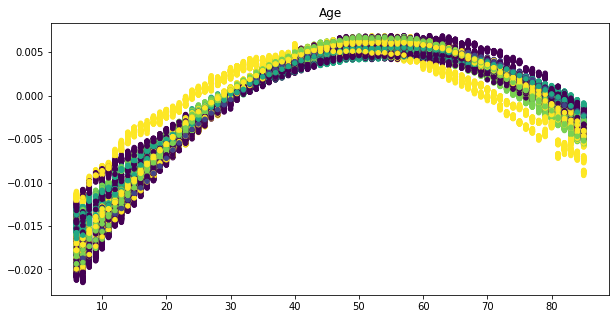

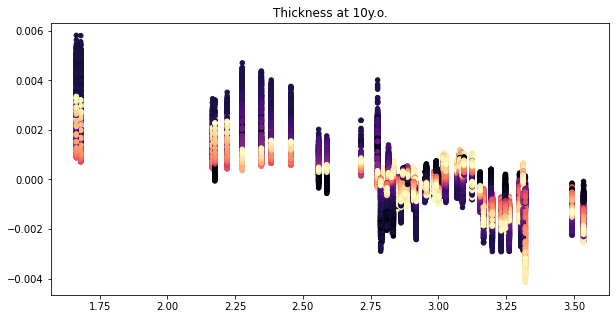

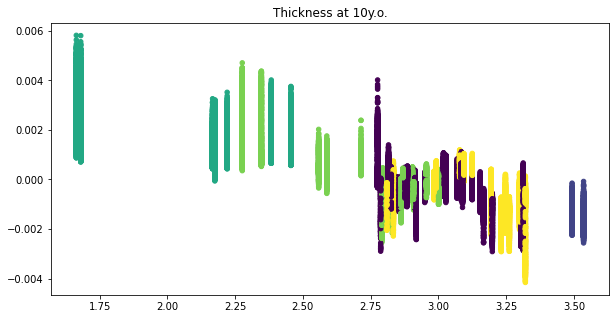

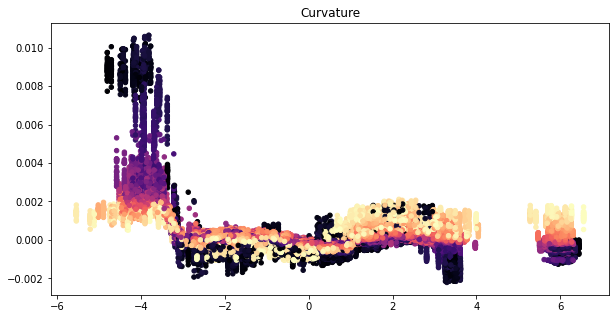

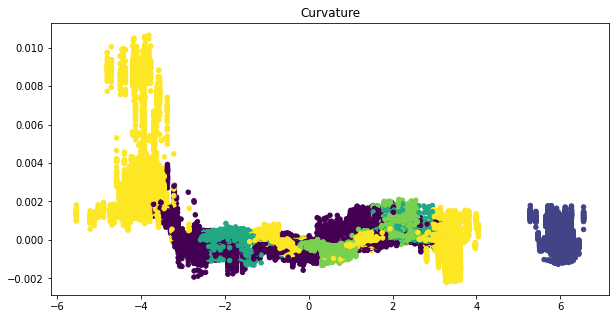

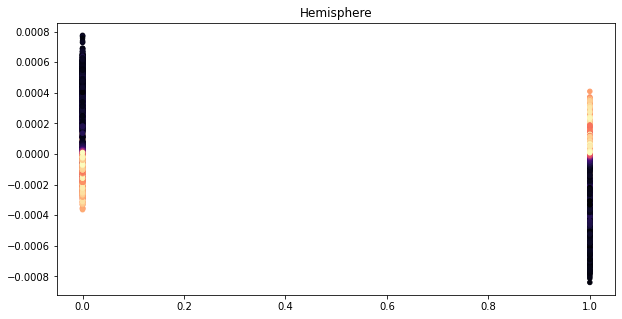

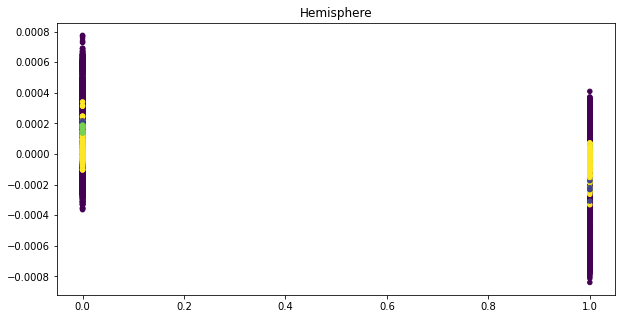

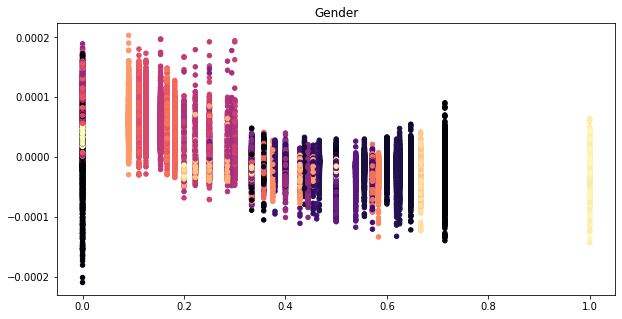

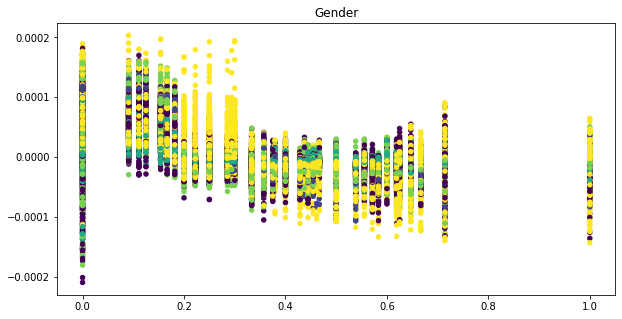

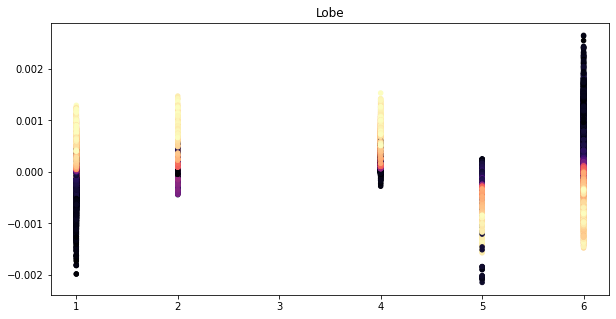

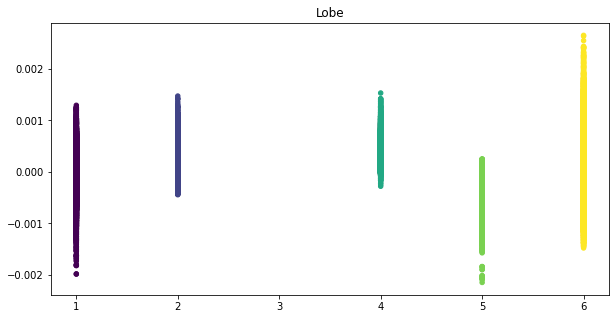

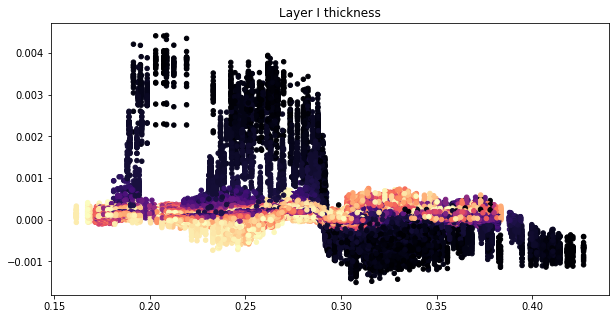

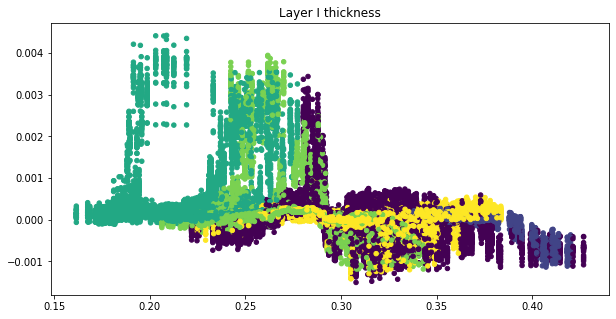

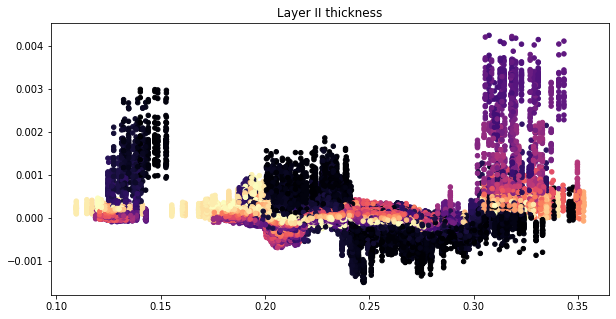

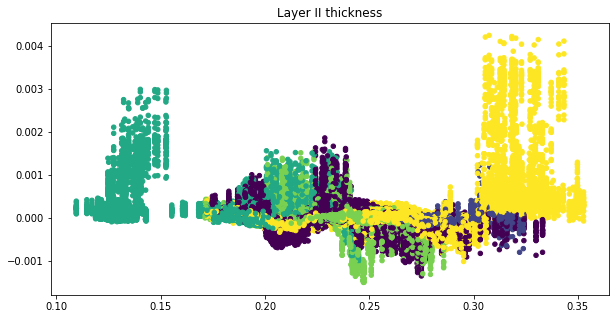

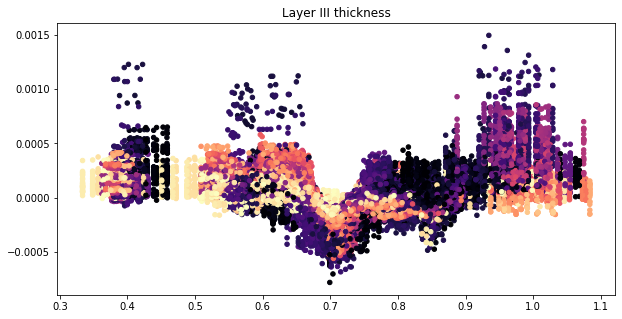

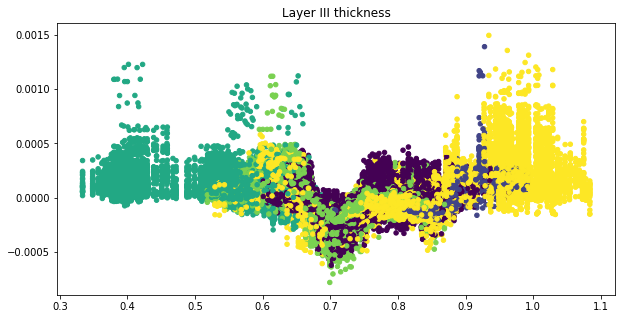

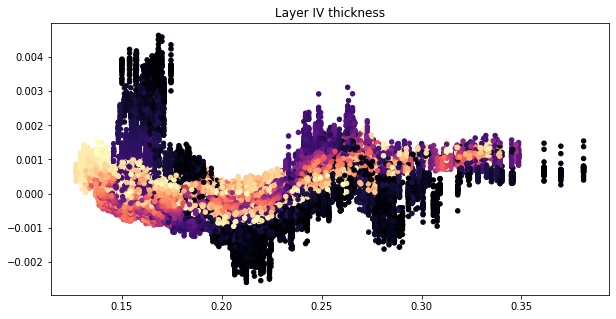

In [ ]:
model = 2
explainer = shap.Explainer(lgbm_dict_list[model][0])
shap_complete = explainer(X_train_dict_list[model][0])
X_train_info = X_train_dict_list[model][0]
for i in tqdm(explicables_index):
    explainer = shap.Explainer(lgbm_dict_list[model][i])
    shap_values = explainer(X_train_dict_list[model][i])
    shap_complete.values = np.append(shap_complete.values, shap_values.values,axis=0)
    shap_complete.base_values = np.append(shap_complete.base_values, shap_values.base_values,axis=0)
    shap_complete.data = np.append(shap_complete.data, shap_values.data,axis=0)
    # criado para definir a cor dos plots
    X_train_info = np.append(X_train_info, X_train_dict_list[model][i], axis=0)
    
# shap plot principal    
shap.summary_plot(shap_complete)

for i in range(12):
    plt.figure(figsize=(10,5))
    plt.title(str(X.columns[i]))
    plt.scatter(shap_complete.data[:,i], shap_complete.values[:,i], alpha=1, c=X_train_info[:,0], cmap=plt.cm.magma, s=20)
    plt.show()
    plt.figure(figsize=(10,5))
    plt.title(str(X.columns[i]))
    plt.scatter(shap_complete.data[:,i], shap_complete.values[:,i], alpha=1, c=X_train_info[:,5], cmap=plt.cm.viridis, s=20)
    plt.show()

In [ ]:
for i in range(len(lgbm_dict)):
    plot_tree(lgbm_dict[i], figsize = (30,30), show_info = ['split_gain','data_percentage'])         

-------------

## 4. Feature Analyses

In [53]:
# Matriz de correlacao
df2corr = df1[['anual_rate','age','thickness10','thickness','curv', 'sulc',
              'thickness_layer_1','thickness_layer_2','thickness_layer_3',
              'thickness_layer_4','thickness_layer_5','thickness_layer_6',
              'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
              'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6']]

f = plt.figure(figsize=(19, 15))
s = 14
data = df2corr.corr()
plt.matshow(data, fignum=f.number)
for (x, y), value in np.ndenumerate(data):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")
plt.xticks(range(df2corr.select_dtypes(['number']).shape[1]), df2corr.select_dtypes(['number']).columns, fontsize=s, rotation=45)
plt.yticks(range(df2corr.select_dtypes(['number']).shape[1]), df2corr.select_dtypes(['number']).columns, fontsize=s)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=s)
plt.title('Correlation Matrix', fontsize=16);
olt.show()

# Boruta
X = df1.drop(columns =['anual_rate', 'structure_name','lobe_name']) 
y = df1.anual_rate

forest = RandomForestRegressor(n_jobs=-1, max_depth=20)
forest.fit(X, y)

feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1, alpha= 0.001)
feat_selector.fit(X.to_numpy(), y)

feature_ranks = list(zip(X.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_,
                         forest.feature_importances_
                        ))
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}, Importance: {}'.format(feat[0], feat[1], feat[2], feat[3]))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
I

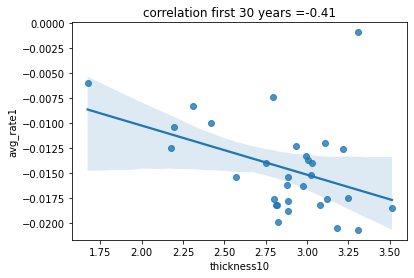

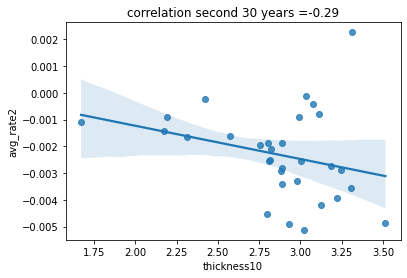

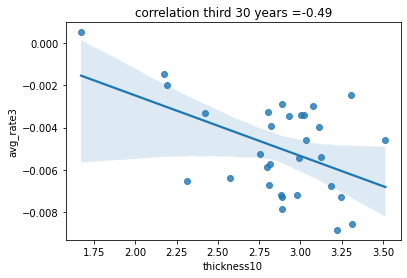

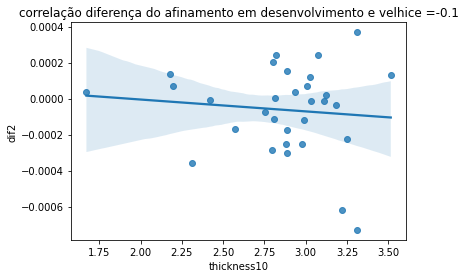

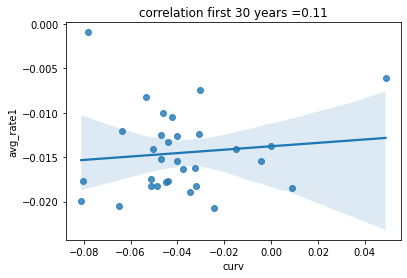

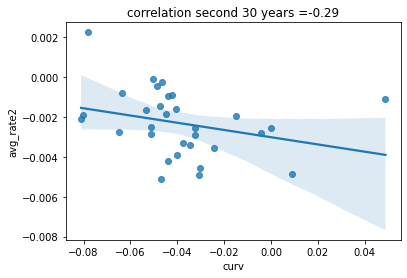

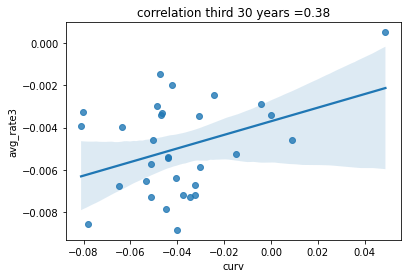

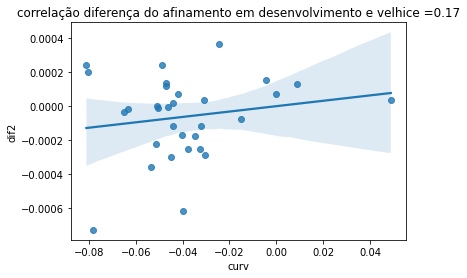

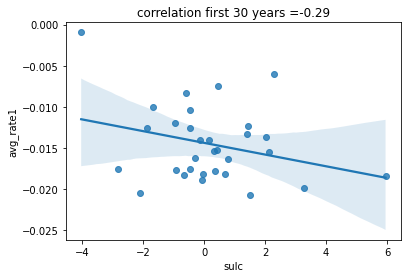

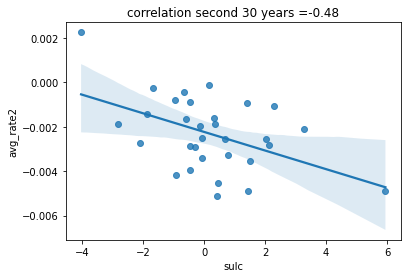

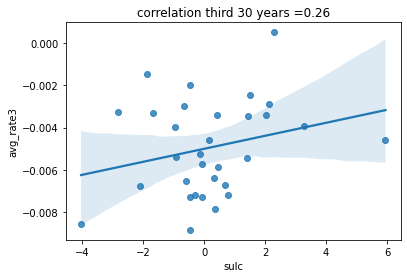

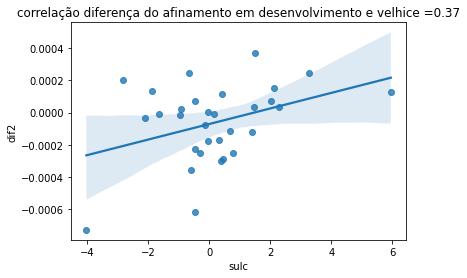

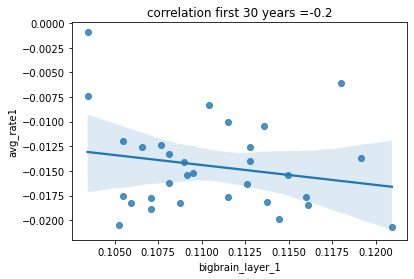

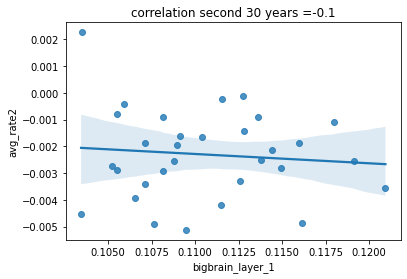

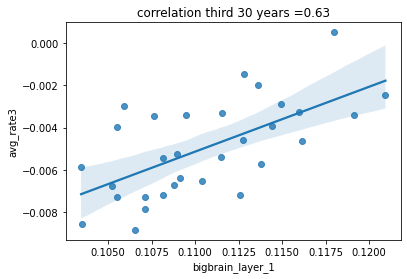

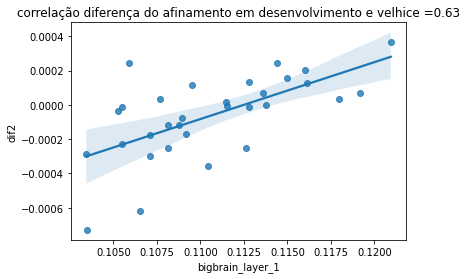

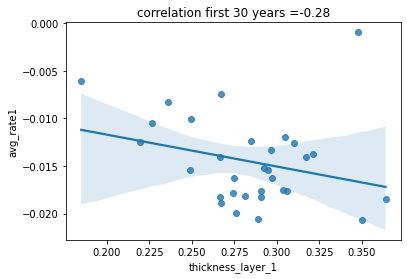

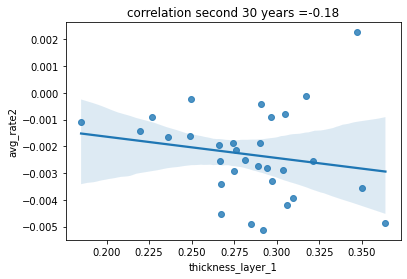

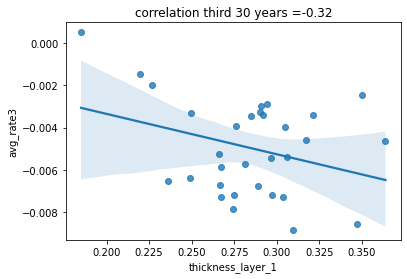

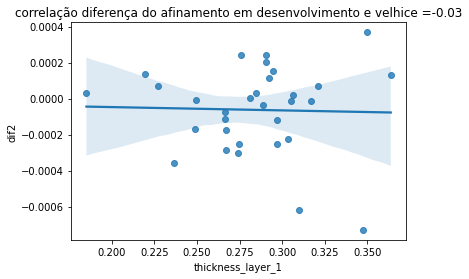

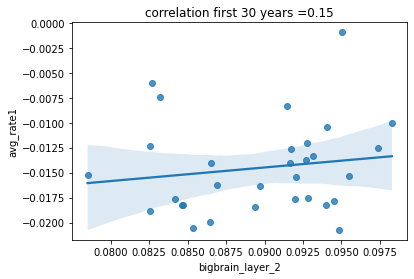

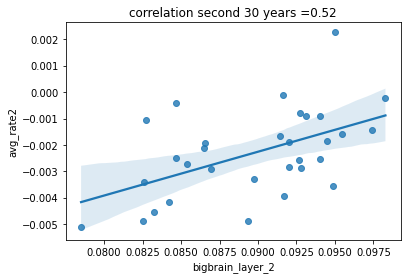

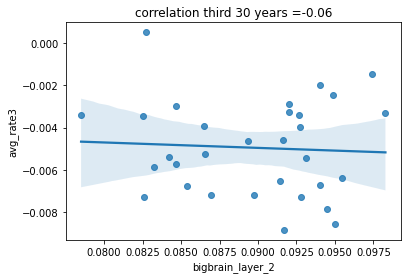

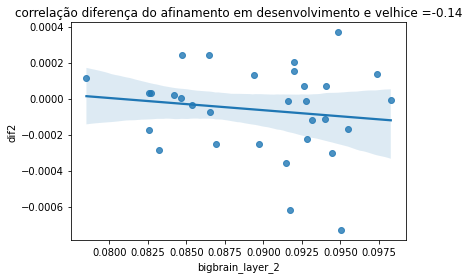

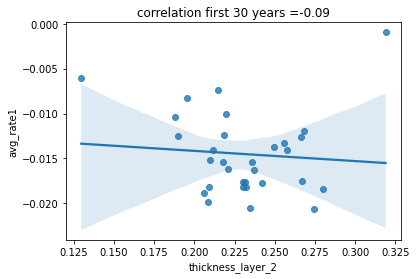

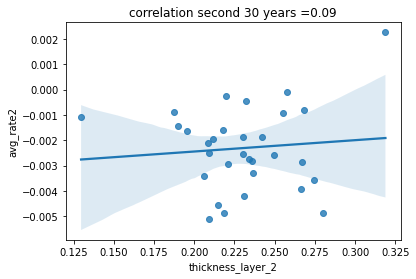

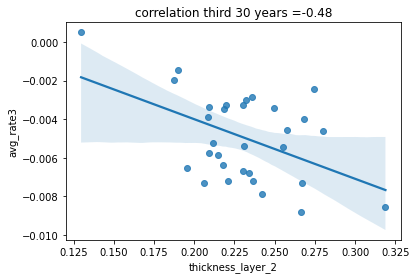

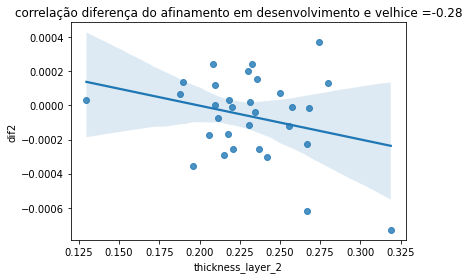

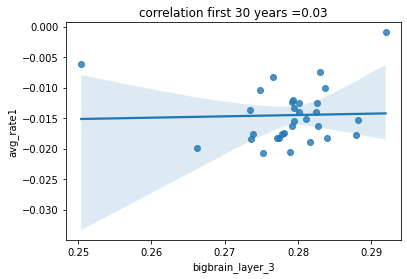

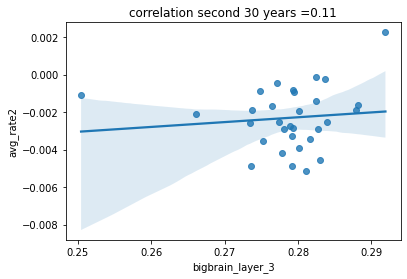

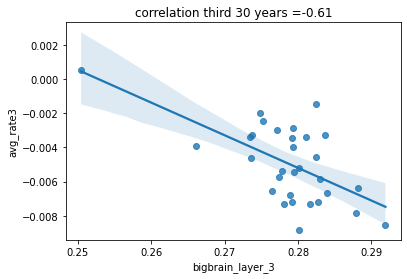

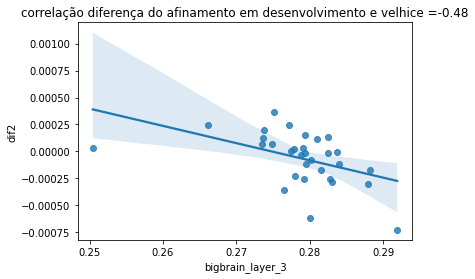

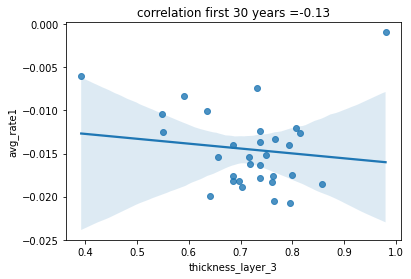

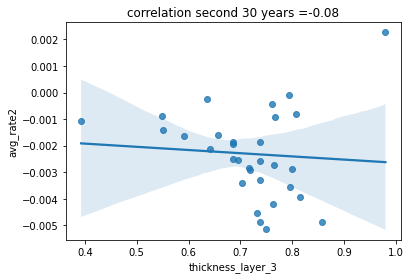

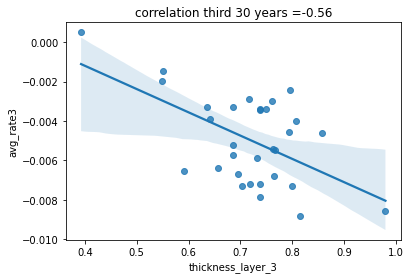

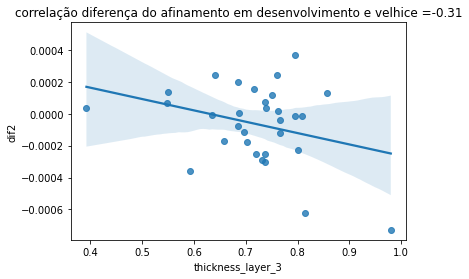

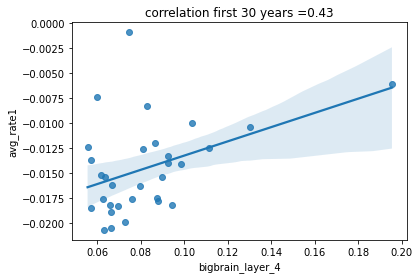

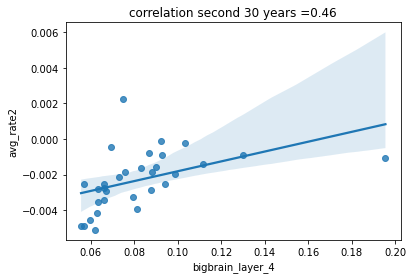

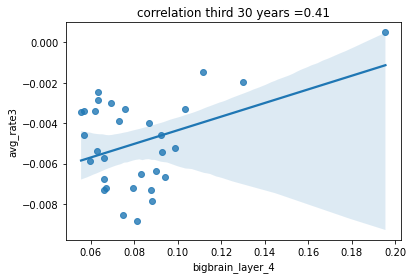

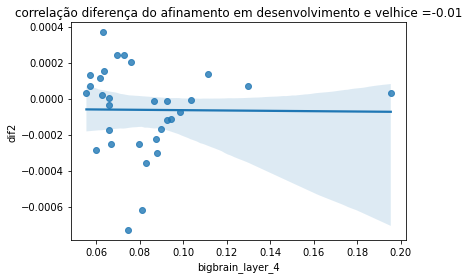

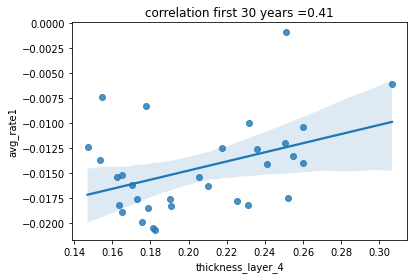

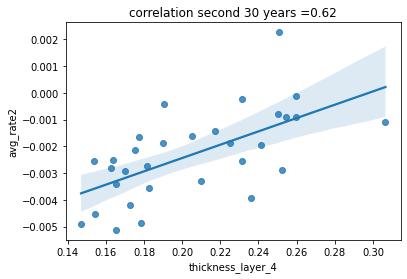

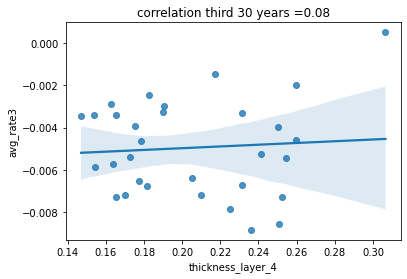

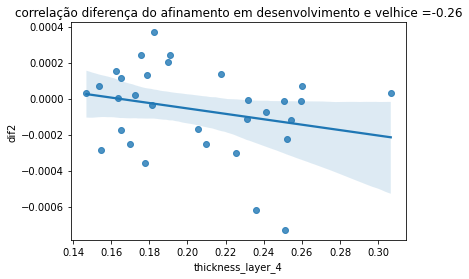

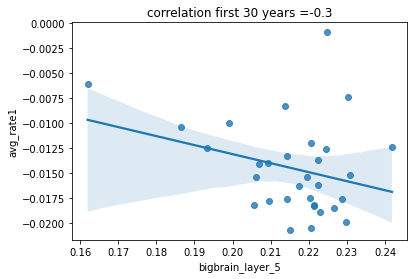

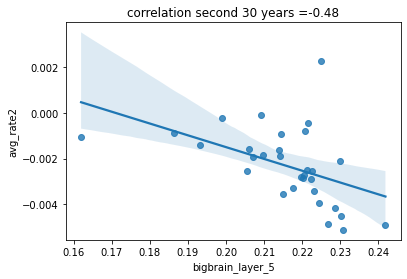

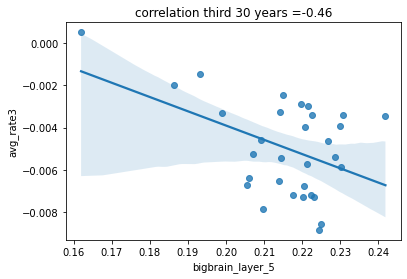

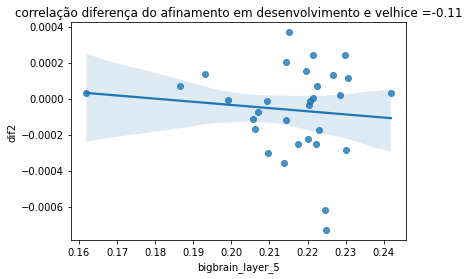

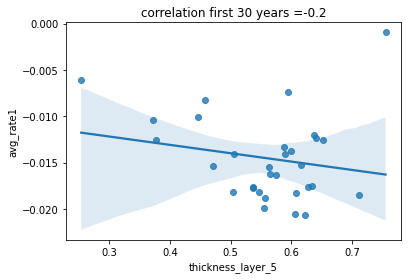

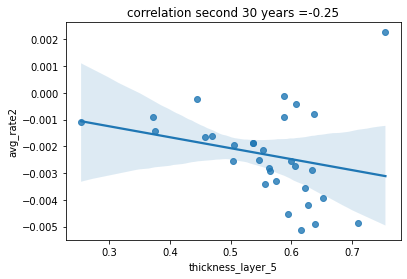

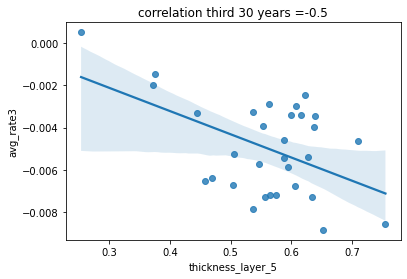

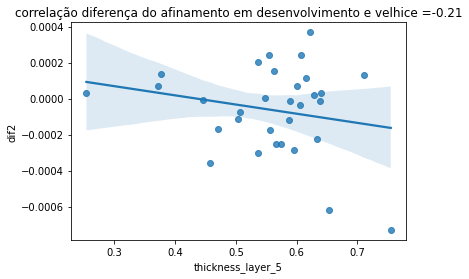

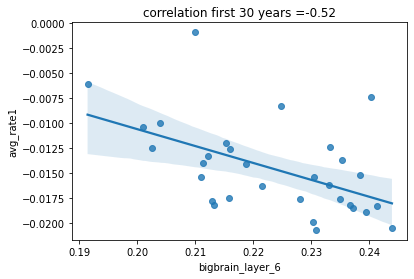

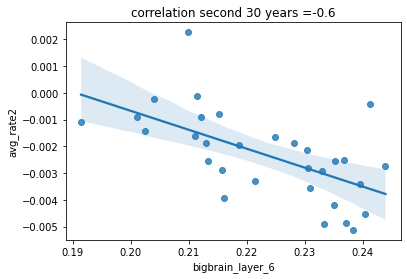

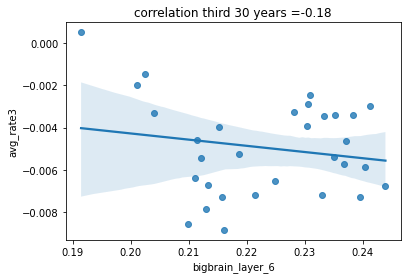

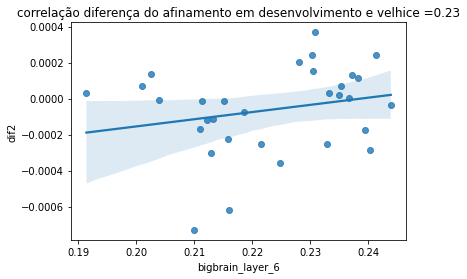

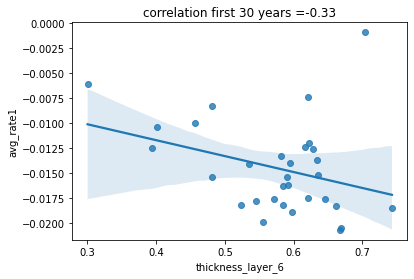

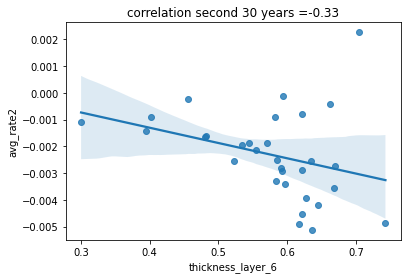

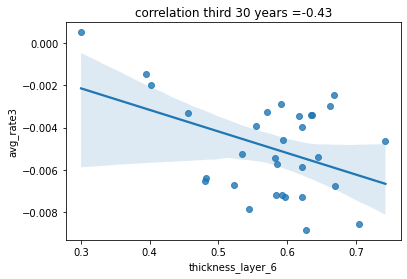

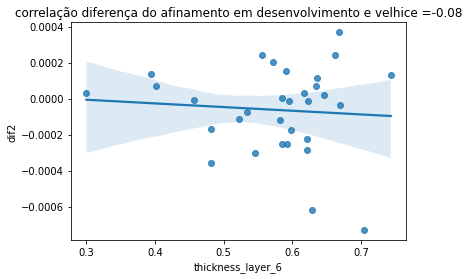

In [55]:
list_avg_rate = []

for i in df1.structure_name.unique():
    
    df5 = df1[df1.structure_name==i]
    
    avg_rate1 = df5[df1.age<=30].anual_rate.mean()
    avg_rate2 = df5[(df1.age<60) & (df1.age>30)].anual_rate.mean()
    avg_rate3 = df5[df1.age>=60].anual_rate.mean()
    
    t10 = df5.thickness10.mean()
    curv = df5.curv.mean()
    sulc = df5.sulc.mean()
    
    l1 = df5.thickness_layer_1.mean()
    b1 = df5.bigbrain_layer_1.mean()
    l2 = df5.thickness_layer_2.mean()
    b2 = df5.bigbrain_layer_2.mean()
    l3 = df5.thickness_layer_3.mean()
    b3 = df5.bigbrain_layer_3.mean()
    l4 = df5.thickness_layer_4.mean()
    b4 = df5.bigbrain_layer_4.mean()
    l5 = df5.thickness_layer_5.mean()
    b5 = df5.bigbrain_layer_5.mean()
    l6 = df5.thickness_layer_6.mean()
    b6 = df5.bigbrain_layer_6.mean()
    
    list_avg_rate.append([i,
                          avg_rate1,avg_rate2,avg_rate3,
                          t10, curv,sulc,
                          b1,l1,
                          b2,l2,
                          b3,l3,
                          b4,l4,
                          b5,l5,
                          b6,l6
                         ])

df5 = pd.DataFrame(list_avg_rate)#.sort_values(by=2)
df5.columns = ['structure_name',
               'avg_rate1', 'avg_rate2', 'avg_rate3',
               'thickness10', # resultados do trabalho do bruno
               'curv', 'sulc',
               'bigbrain_layer_1', 
               'thickness_layer_1', # resultados sofrem interferencia da espessura inicial
               'bigbrain_layer_2', 
               'thickness_layer_2',
               'bigbrain_layer_3', 
               'thickness_layer_3',
               'bigbrain_layer_4', 
               'thickness_layer_4',
               'bigbrain_layer_5', 
               'thickness_layer_5',
               'bigbrain_layer_6', 
               'thickness_layer_6'
               ]

df5['dif2'] = df5.avg_rate1*df5.avg_rate1 - df5.avg_rate3*df5.avg_rate3*10
        
for test in df5.columns[4:-1]:

    corr = np.corrcoef(df5[test],df5.avg_rate1)[0, 1]
    sns.regplot(x=test,y='avg_rate1', data=df5).set(
        title="correlation first 30 years ="+ str(np.round(corr,2)))
    plt.show()

    corr = np.corrcoef(df5[test],df5.avg_rate2)[0, 1]
    sns.regplot(x=test,y='avg_rate2', data=df5).set(
        title="correlation second 30 years ="+ str(np.round(corr,2)))
    plt.show()

    corr = np.corrcoef(df5[test],df5.avg_rate3)[0, 1]
    sns.regplot(x=test,y='avg_rate3', data=df5).set(
        title="correlation third 30 years ="+ str(np.round(corr,2)))
    plt.show()
    
    corr = np.corrcoef(df5[test],df5.dif2)[0, 1]
    sns.regplot(x=test,y='dif2', data=df5).set(
    title="correlação diferença do afinamento em desenvolvimento e velhice ="+ str(np.round(corr,2)))
    plt.show()

df5.corr()

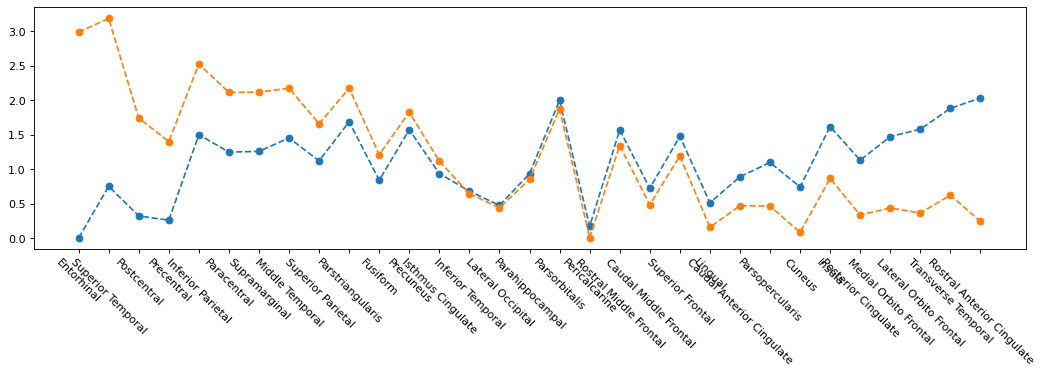

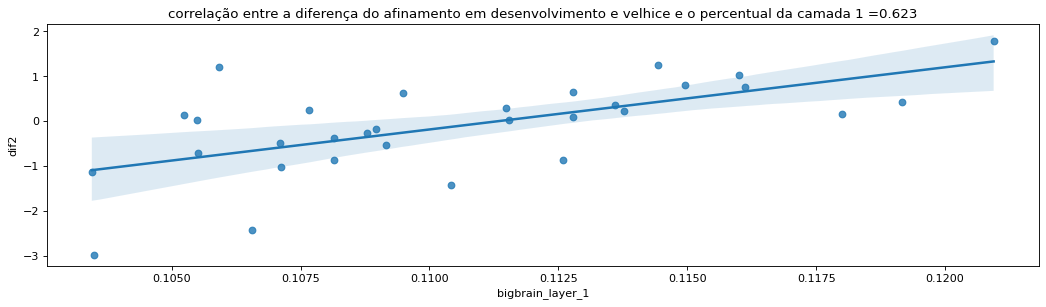

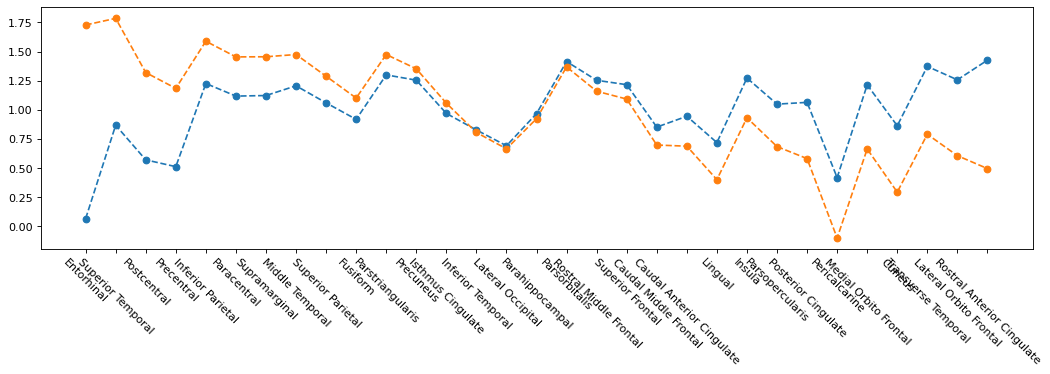

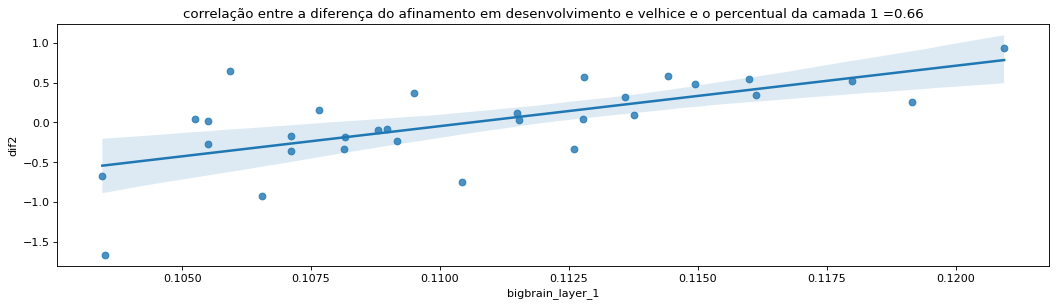

In [58]:
# calculando teste estatistico
df5_n = df5.copy()
df5_n['avg_rate1'] = df5['avg_rate1']/(df5['avg_rate1'].mean())
df5_n['avg_rate2'] = df5['avg_rate2']/(df5['avg_rate2'].mean())
df5_n['avg_rate3'] = df5['avg_rate3']/(df5['avg_rate3'].mean())

df5_n['dif2'] = df5_n.avg_rate1*df5_n.avg_rate1 - df5_n.avg_rate3*df5_n.avg_rate3
#df5_n['dif2'] = df5_n.avg_rate1 - df5_n.avg_rate3

x1 = -0.4 #[0.4;0.7]
x2 = -x1
g1 = df5_n[df5_n.dif2<x1]
g2 = df5_n[(df5_n.dif2>x1) & (df5_n.dif2<x2)]
g3 = df5_n[df5_n.dif2>x2]

print(len(g1), len(g2), len(g3))
print(g1.bigbrain_layer_1.mean(), g2.bigbrain_layer_1.mean(), g3.bigbrain_layer_1.mean())
from scipy import stats 
print(stats.kruskal(g1.bigbrain_layer_1,g2.bigbrain_layer_1,g2.bigbrain_layer_1)[1])
print(stats.f_oneway(g1.bigbrain_layer_1,g2.bigbrain_layer_1,g2.bigbrain_layer_1)[1])

# criando imagens
df5_n['dif2'] = df5_n.avg_rate1*df5_n.avg_rate1 - df5_n.avg_rate3*df5_n.avg_rate3
df5_n = df5_n.sort_values(by = 'dif2')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate1*df5_n.avg_rate1, '--o') 
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate3*df5_n.avg_rate3, '--o')
plt.xticks(rotation = -45) 
plt.show()

plt.figure(figsize=(16, 4), dpi=80)
corr = np.corrcoef(df5_n['bigbrain_layer_1'],df5_n.dif2)[0, 1]
sns.regplot(x='bigbrain_layer_1',y='dif2', data=df5_n).set(
    title="correlação entre a diferença do afinamento em desenvolvimento e velhice e o percentual da camada 1 ="+ str(np.round(corr,3)))
plt.show()

df5_n['dif2'] = df5_n.avg_rate1 - df5_n.avg_rate3
df5_n = df5_n.sort_values(by = 'dif2')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate1, '--o') 
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate3, '--o')
plt.xticks(rotation = -45) 
plt.show()

plt.figure(figsize=(16, 4), dpi=80)
corr = np.corrcoef(df5_n['bigbrain_layer_1'],df5_n.dif2)[0, 1]
sns.regplot(x='bigbrain_layer_1',y='dif2', data=df5_n).set(
    title="correlação entre a diferença do afinamento em desenvolvimento e velhice e o percentual da camada 1 ="+ str(np.round(corr,3)))
plt.show()

-------------

## 5. Old but important Code

#### 5.1. Criando anualrate.parquet

In [ ]:
# freesufer data
mri_subs_all = pp.read_parquet(mri_subs_path)
print('freesufer data')

# drop zeros and encode cats
mri_subs = pp.clean(mri_subs_all)
print('drop zeros and encode cats')

# quality assessment
bad_participants = pp.find_bad_ones(mri_areas_path)
mri_subs = pp.eliminate_bad_ones(bad_participants, mri_subs)
print('quality assessment')

# add identification features
mri_subs = pp.cat2int(mri_subs, cat_features=['sex', 'handedness', 'hemisphere'])
print('add identification features')

# add h_atlasDF
mri_subs['h_atlasDF'] = mri_subs.hemisphere.astype(str) + mri_subs.atlasDF.astype(str)
print('add h_atlasDF')

# add name atlas
print('add name strutures')


# add bigbrain features
mri_subs = pp.bb_features(bb_path, mri_subs)
print('add bigbrain')

# h_atlasDF to int
mri_subs['h_atlasDF'] = mri_subs['h_atlasDF'].replace('0-1', '-1')
mri_subs['h_atlasDF'] = mri_subs['h_atlasDF'].replace('1-1', '-1')
mri_subs.h_atlasDF.unique()

# create dict_groupby 
dict_groupby = {}
keys = ['participant',  'age', 'sex', 'handedness',
        'hemisphere', 'atlasDF', 'area', 'curv','sulc', 'thickness', 
        'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3','bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6']

for key in keys:
    dict_groupby[key] = []
dict_groupby['h_atlasDF'] = []
print('create dict_groupby')

for i, participant in enumerate(mri_subs.participant.unique()):
    
    df = mri_subs[mri_subs.participant == participant].groupby(['h_atlasDF']).mean()
    df['participant_i'] = i
    df['participant'] = participant
    print(i)
    
    for key in keys:
        dict_groupby[key].extend(df[key])
    dict_groupby['h_atlasDF'].extend(df.index)

df0 = pd.DataFrame(dict_groupby)

df0.to_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet")
df0.head()

#### 5.2. Criando Age_Stable.csv

In [ ]:
#derivada = taxa_anual.idxmax(axis=1)
#derivada = derivada.reset_index()
#derivada['hemisferio'] = [a[0] for a in derivada['atlasEcono']]
#derivada['atlasEcono'] = [a[1:] for a in derivada['atlasEcono']]
#derivada['bigest_slope'] = np.array(taxa_anual.min(axis=1))
#derivada = derivada.rename(columns={'atlasEcono':'econo',0:'age_stable'})
#derivada.to_csv('/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Age_Stable.csv')